 # Image Captioning Trials

In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential, Model
from onedrivedownloader import download
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL
import datetime
import requests
from tensorboard.plugins.hparams import api as hp
import visualkeras
import zipfile
import json
from tqdm import tqdm
import collections
import nltk
from nltk.translate.bleu_score import corpus_bleu
import time

# Make sure to download NLTK data for BLEU if not already installed
nltk.download('punkt')

2024-10-24 17:14:24.196634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 17:14:24.213835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 17:14:24.217503: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 17:14:24.236193: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 17:14:25.170230: W tensorflow/compiler/tf2

True

In [3]:


os.environ['CUDA_VISIBLE_DEVICES'] = "0"

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        # Enable memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

I0000 00:00:1729782868.951250   54373 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729782869.013412   54373 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729782869.015029   54373 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729782869.018043   54373 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs



 ## Loading the COCO dataset

In [4]:
# URLs for the zip files
annotations_url = "https://viacesifr-my.sharepoint.com/:u:/r/personal/salma_turki_viacesi_fr/Documents/COCO%20Dataset/annotations_trainval2014.zip?csf=1&web=1&e=JJ2vXX&download=1"
train2014_url = "https://viacesifr-my.sharepoint.com/:u:/r/personal/salma_turki_viacesi_fr/Documents/COCO%20Dataset/train2014.zip?csf=1&web=1&e=e4CdT1&download=1"

# Local paths
annotation_folder = os.path.join(".", "annotations")
train2014_folder = os.path.join(".", "train2014")
annotation_zip = os.path.join(".", "annotations.zip")
train2014_zip = os.path.join(".", "train2014.zip")

# Check if the folders already exist
if not os.path.exists(annotation_folder):
    print("annotations folder not found. Downloading...")
    # Download the annotations.zip file
    response = requests.get(annotations_url, stream=True)
    with open(annotation_zip, 'wb') as f:
        shutil.copyfileobj(response.raw, f)
    del response

    # Unzip the annotations.zip
    print("Extracting annotations.zip...")
    with zipfile.ZipFile(annotation_zip, 'r') as zip_ref:
        zip_ref.extractall(annotation_folder)

    # Delete the annotations.zip file
    print("Deleting annotations.zip...")
    os.remove(annotation_zip)

if not os.path.exists(train2014_folder):
    print("train2014 folder not found. Downloading...")
    # Download the train2014.zip file
    response = requests.get(train2014_url, stream=True)
    with open(train2014_zip, 'wb') as f:
        shutil.copyfileobj(response.raw, f)
    del response

    # Unzip the train2014.zip
    print("Extracting train2014.zip...")
    with zipfile.ZipFile(train2014_zip, 'r') as zip_ref:
        zip_ref.extractall(train2014_folder)

    # Delete the train2014.zip file
    print("Deleting train2014.zip...")
    os.remove(train2014_zip)

print("Download and extraction completed.")

Download and extraction completed.


In [5]:


def get_feature_extraction_model(model_choice='InceptionV3'):
    """
    Returns the feature extraction model, preprocessing function, image size, and feature shapes based on the chosen model.
    """
    if model_choice == 'InceptionV3':
        image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
        preprocess_input = tf.keras.applications.inception_v3.preprocess_input
        img_size = (299, 299)  # Image size required for InceptionV3
        attention_features_shape = 64  # 8 * 8
        features_shape = 2048  # Depth of the feature map
    elif model_choice == 'ResNet50':
        image_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
        preprocess_input = tf.keras.applications.resnet50.preprocess_input
        img_size = (224, 224)  # Image size required for ResNet50
        attention_features_shape = 49  # 7 * 7
        features_shape = 2048  # Depth of the feature map
    else:
        raise ValueError("model_choice must be either 'InceptionV3' or 'ResNet50'")

    new_input = image_model.input
    hidden_layer = image_model.layers[-1].output
    image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

    return image_features_extract_model, preprocess_input, img_size, features_shape, attention_features_shape

In [6]:


model_choice = 'InceptionV3'  # Change this to 'ResNet50' to use ResNet
image_features_extract_model, preprocess_input, img_size, features_shape, attention_features_shape = get_feature_extraction_model(model_choice)

In [7]:


# model_choice = 'ResNet50'  # Change this to 'InceptionV3' to use ResNet
# image_features_extract_model, preprocess_input, img_size, features_shape, attention_features_shape = get_feature_extraction_model(model_choice)

In [8]:


# Annotation file path
annotation_file = os.path.join(annotation_folder, "captions_train2014.json")

# Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Group all annotations with the same identifier.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # mark the beginning and end of each annotation
    caption = f"<start> {val['caption']} <end>"
    # An image's identifier is part of its access path.
    image_path = os.path.join(train2014_folder, 'COCO_train2014_' + '%012d.jpg' % (val['image_id']))
    # Add caption to image_path
    image_path_to_caption[image_path].append(caption)
    
# Take first images only
image_paths = list(image_path_to_caption.keys())
train_image_paths = image_paths[:5000]

# List of all annotations
train_captions = []
# List of all duplicated image file names (in number of annotations per image)
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    # Add caption_list to train_captions
    train_captions.extend(caption_list)
    # Add duplicate image_path len(caption_list) times
    img_name_vector.extend([image_path] * len(caption_list))

print(f"Number of images: {len(train_image_paths)}")

Number of images: 5000


In [9]:


# Function to load and preprocess image
def load_image(image_path):
    """
    Load and preprocess the image according to the model (InceptionV3 or ResNet50)
    The load_image function has as input the path of an image and as output a pair
    pair containing the processed image and its path.
    The load_image function performs the following processing:
        1. Loads the file corresponding to the path image_path
        2. Decodes the image into RGB.
        3. Resize image.
        4. Normalize image pixels between -1 and 1.
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)  # Adjust image size based on model
    img = preprocess_input(img)  # Preprocess input according to selected model
    return img, image_path

# Image preprocessing for the dataset
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(8)

# Batch processing for feature extraction
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

# Display batch features shape
for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    print(f"Batch features shape: {batch_features.shape}")
    break

  0%|          | 0/625 [00:00<?, ?it/s]2024-10-24 17:14:32.295945: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1729782872.354741   54373 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729782872.369827   54373 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729782872.371568   54373 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729782872.378112   54373 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729782872.380436   54373 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729782872.382724   54373 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729782872.384802   54373 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W000

Batch features shape: (8, 8, 8, 2048)



 ## Pre-processing


 ### Annotation pre-processing

In [10]:


# Find the maximum size
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Choose the 5000 most frequent words in the vocabulary
top_k = 5000
# The Tokenizer class enables text pre-processing for neural networks
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# Builds a vocabulary based on the train_captions list
tokenizer.fit_on_texts(train_captions)

# Create the token used to fill annotations to equalize their length
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Creation of vectors (list of integer tokens) from annotations (list of words)
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Fill each vector up to the maximum annotation length
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the maximum length used to store attention weights
# It will later be used for display during evaluation.
max_length = calc_max_length(train_seqs)


 ### Formation of a training and test set

In [11]:


img_to_cap_vector = collections.defaultdict(list)
# Creation of a dictionary associating image paths (.npy file) with annotations 
# # Images are duplicated because there are several annotations per image
print(len(img_name_vector), len(cap_vector))
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

"""
Creation of training and validation datasets 
using a random 80-20 split
""" 
# Take the keys (names of processed image files), *these will not be duplicated*.
img_keys = list(img_to_cap_vector.keys())
# Dividing clues into training and testing
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

"""
Training and test games are in the form of
lists containing mappings:(pre-processed image ---> annotation token(word) )
"""

# Loop to build the training set
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    # Duplication of images by number of annotations per image
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

# Loop to build the test set
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    # Duplication of images by number of annotations per image
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

25011 25011


(20008, 20008, 5003, 5003)

In [12]:


BATCH_SIZE = 16 # batch size
BUFFER_SIZE = 1000 # buffer size for data mixing
embedding_dim = 256
units = 512 # Hidden layer size in RNN
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# Function that loads numpy files from pre-processed images
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

# Creation of a "Tensor "s dataset (used to represent large datasets)
# The dataset is created from "img_name_train" and "cap_train".
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load numpy files (possibly in parallel)
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Mixing data and dividing them into batches
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [13]:


import tensorflow as tf
from abc import ABC, abstractmethod

# Base Encoder Class
class BaseEncoder(tf.keras.Model, ABC):
    @abstractmethod
    def call(self, x):
        pass

# Base Decoder Class
class BaseDecoder(tf.keras.Model, ABC):
    @abstractmethod
    def call(self, x, features, hidden):
        pass


 ## CNN

In [14]:


class CNN_Encoder(BaseEncoder):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


 ## Attention mechanisms


 ### Bahdanau

In [15]:


class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        # W1 is the hidden layer for image features
        self.W1 = tf.keras.layers.Dense(units)
        # W2 is the hidden layer for the previous hidden layer
        self.W2 = tf.keras.layers.Dense(units)
        # V is the output layer that gives a non-normalized score for each image feature
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

        # This gives you a non-normalized score for each image feature.
        score = self.V(attention_hidden_layer)

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights




 ## RNN


 ### GRU


 #### 1 layer

In [16]:


class RNN_Decoder_GRU(BaseDecoder):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder_GRU, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # self.gru = tf.keras.layers.GRU(self.units,
        #                                return_sequences=True,
        #                                return_state=True,
        #                                recurrent_initializer='glorot_uniform')
        self.gru = tf.keras.layers.RNN(tf.keras.layers.GRUCell(self.units), return_sequences=True, return_state=True)
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        
        # Ensure x has a time dimension
        x = self.embedding(x)
        if len(x.shape) == 2:  # if shape is [batch_size, embedding_dim]
            x = tf.expand_dims(x, 1)  # expand dims to [batch_size, 1, embedding_dim]
        
        # Concatenate context vector with x
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # Pass the concatenated tensor to the GRU
        output, state = self.gru(x)

        y = self.fc1(output)
        y = tf.reshape(y, (-1, y.shape[2]))  # Flatten before final Dense layer
        y = self.fc2(y)

        return y, state, attention_weights


    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


 #### 3 layers

In [17]:


class RNN_Decoder_GRU_3L(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder_GRU_3L, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # self.gru = tf.keras.layers.GRU(self.units, # Taille de la couche cachée du GRU
        #                                return_sequences=True, # retourne la séquence complète de sortie de chaque pas de temps
        #                                return_state=True, # retourne l'état caché de la dernière étape de temps
        #                                recurrent_initializer='glorot_uniform') # glorot_uniform est une initialisation des poids qui permet de mieux converger lors de l'entrainement en utilisant la fonction d'activation relu ce qui fait que les poids sont initialisés de manière à ce que la variance de la sortie soit égale à la variance de l'entrée
        # 3 couches de GRU
        self.gru1 = tf.keras.layers.RNN(tf.keras.layers.GRUCell(self.units), return_sequences=True, return_state=True)
        self.gru2 = tf.keras.layers.RNN(tf.keras.layers.GRUCell(self.units), return_sequences=True, return_state=True)
        self.gru3 = tf.keras.layers.RNN(tf.keras.layers.GRUCell(self.units), return_sequences=True, return_state=True)
        #Couche dense qui aura pour entrée la sortie du GRU
        self.fc1 = tf.keras.layers.Dense(self.units)
        # Dernière couche dense
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # L'attention est defini par un modèle a part
        context_vector, attention_weights = self.attention(features, hidden)
        # Passage du mot courant à la couche embedding
        x = self.embedding(x)
        # Concaténation
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) #DONE tf.expand_dims permet de rajouter une dimension à un tenseur à une position donnée

        # Passage du vecteur concaténé à la gru
        output, state = self.gru1(x)
        output, state = self.gru2(output)
        output, state = self.gru3(output)
        
        # Couche dense
        y = self.fc1(output)

        y = tf.reshape(y, (-1, x.shape[2])) # Aplatir le tenseur pour le passer à la couche dense suivante (fc2)
        
        # Couche dense
        y = self.fc2(y)
        
        return y, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


 ### LSTM

In [18]:


class RNN_Decoder_LSTM(BaseDecoder):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder_LSTM, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True)
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, hidden_state, cell_state = self.lstm(x)
        print("OUTPUT:", output.shape)
        y = self.fc1(output)
        y = tf.reshape(y, (-1, x.shape[2]))
        y = self.fc2(y)
        return y, hidden_state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

### Bidirectional LSTM

In [19]:
class RNN_Decoder_Bidirectional_LSTM(BaseDecoder):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder_Bidirectional_LSTM, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True))
        # self.lstm = tf.keras.layers.LSTM(self.units, return_sequences=True, return_state=True)
        self.fc0 = tf.keras.layers.Dense(self.units)
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)
        self.fc_hidden = tf.keras.layers.Dense(self.units)
        
    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        bi_output, forward_h, forward_c, backward_h, backward_c = self.bilstm(x)
        bi_output = self.fc0(bi_output)
        reduced_hidden = tf.concat([forward_h, backward_h], axis=1)
        reduced_hidden = self.fc_hidden(reduced_hidden)
        # output, hidden_state, cell_state = self.lstm(bi_output)
        # print("OUTPUT:", output.shape)
        y = self.fc1(bi_output)
        y = tf.reshape(y, (-1, x.shape[2]))
        y = self.fc2(y)
        return y, reduced_hidden, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))



 ## Training

In [20]:


# Create Model
def create_model(encoder_class, decoder_class, embedding_dim, units, vocab_size):
    encoder = encoder_class(embedding_dim)
    decoder = decoder_class(embedding_dim, units, vocab_size)
    return encoder, decoder

# Tokenization and BLEU evaluation functions
def tokenize_captions(captions, tokenizer):
    return [tokenizer.texts_to_sequences([cap])[0] for cap in captions]

def decode_predictions(preds, tokenizer):
    pred_captions = []
    for pred in preds:
        decoded_sentence = []
        for idx in pred:
            if idx == tokenizer.word_index['<end>']:
                break
            decoded_sentence.append(tokenizer.index_word[idx])
        pred_captions.append(decoded_sentence)
    return pred_captions

In [21]:


# Optimiseur ADAM
optimizer = tf.keras.optimizers.Adam() #DONE
# La fonction de perte
# SparseCategoricalCrossentropy est une fonction de perte qui est utilisée pour les problèmes de classification multi-classes. Elle est utilisée lorsque les étiquettes sont des entiers et non pas des vecteurs one-hot.
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') 

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [22]:


# Validation step on separate validation dataset
loss_plot = []
@tf.function
def validation_step(img_tensor, target, encoder, decoder):
    loss = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    # Initialiser l'entrée du décodeur
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: # Offre la possibilité de calculer le gradient du loss
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct à l'étap i est donné en entrée à l'étape (i+1)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1])) # Calcul de la perte moyenne par mot du batch courant

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss


 ## Model 1
Bidirectional LSTM with Bahdanau attention and ResNet50

In [23]:
# Optimizer and Checkpoint Management
checkpoint_path = "./checkpoints/bi-lstm-attention"

In [24]:
def train_model(encoder, decoder, ckpt_manager, start_epoch=0):
    # Modified training loop with BLEU score calculation
    EPOCHS = 20

    for epoch in range(start_epoch, EPOCHS):
        start = time.time()
        total_loss = 0
        
        for (batch, (img_tensor, target)) in enumerate(dataset):
            batch_loss, t_loss = validation_step(img_tensor, target, encoder, decoder)
            total_loss += t_loss

            if batch % 100 == 0:
                print ('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
        # sauvegarde de la perte
        loss_plot.append(total_loss / num_steps)

        if epoch % 5 == 0:
            ckpt_manager.save()

        print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                            total_loss/num_steps))
        print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    # Affichage de la courbe d'entrainement
    plt.plot(loss_plot)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Plot')
    plt.show()

In [25]:


# Function to evaluate the image captioning model
def evaluate(image, encoder, decoder):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, attention_plot

# Function to display the BLEU score
def display_bleu_score(image, result):
    references = []

    # Display image
    image_show = PIL.Image.open(image)
    plt.imshow(image_show)
    plt.axis('off')
    plt.show()

    print("\n" + "*" * 60)
    print("Predicted Caption :")
    print(' '.join(result))

    # Find the corresponding references (captions) for this specific image
        # Find the corresponding references (captions) for this specific image
    for i, img_name in enumerate(img_name_val):
        if img_name == image:  # Compare with the image being processed
            ref = []
            for token in cap_val[i]:
                if token != 0:  # Ignore padding (0)
                    word = tokenizer.index_word.get(token, '<unk>')  # Handle missing tokens
                    ref.append(word)
            references.append(ref)
    print("\n" + "*" * 60)
    print("References :")
    for ref in references[:5]:
        print(' '.join(ref))

    print("...")

    # Convert references for BLEU score evaluation
    references_tokenized = [references]  # Multiple references for a single image

    # Since we're calculating BLEU for a single image, ensure predictions are used as a single list
    predictions = [result]  # Make the predicted caption a single hypothesis list

    # Calculate BLEU scores
    bleu_1 = corpus_bleu(references_tokenized, predictions, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(references_tokenized, predictions, weights=(0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(references_tokenized, predictions, weights=(0.33, 0.33, 0.33, 0))
    bleu_4 = corpus_bleu(references_tokenized, predictions, weights=(0.25, 0.25, 0.25, 0.25))

    # Print BLEU scores
    print("\n" + "*" * 60)
    print(f"BLEU Score :")
    print(f"unigram  = {bleu_1:.10f}")
    print(f"bigram   = {bleu_2:.10f}")
    print(f"trigram  = {bleu_3:.10f}")
    print(f"4-gram = {bleu_4:.10f}")
    print("*" * 60)

# Function for visualizing attention on the image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(PIL.Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result // 2, len_result // 2, l + 1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [26]:
# Instantiate encoder and decoder
encoder, decoder = create_model(CNN_Encoder, RNN_Decoder_Bidirectional_LSTM, embedding_dim, units, vocab_size)

# Checkpoint setup
ckpt = tf.train.Checkpoint(encoder=encoder, 
                           decoder=decoder, 
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, 
                                          checkpoint_path, 
                                          max_to_keep=5)

# Resume training from last checkpoint if exists
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)
    if ckpt_manager.latest_checkpoint:
        print(f"Restored from {ckpt_manager.latest_checkpoint}")
        print(f"Resuming training from epoch {start_epoch}")

Restored from ./checkpoints/bi-lstm-attention/ckpt-7
Resuming training from epoch 7


/home/arslane/Documents/CESI/DataScience/image_captioning_full_pipeline/.venv/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:731: UserWarning: Gradients do not exist for variables ['kernel', 'kernel', 'kernel', 'bias', 'kernel'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 1 Batch 0 Loss 1.3308
Epoch 1 Batch 100 Loss 0.6665
Epoch 1 Batch 200 Loss 0.6181
Epoch 1 Batch 300 Loss 0.6507
Epoch 1 Batch 400 Loss 0.6929
Epoch 1 Batch 500 Loss 0.5760
Epoch 1 Batch 600 Loss 0.6114
Epoch 1 Batch 700 Loss 0.6629
Epoch 1 Batch 800 Loss 0.8464
Epoch 1 Batch 900 Loss 0.7834
Epoch 1 Batch 1000 Loss 0.7182
Epoch 1 Batch 1100 Loss 0.5745
Epoch 1 Batch 1200 Loss 0.5548


2024-10-23 14:26:13.988737: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 Loss 0.661850
Time taken for 1 epoch 451.702716588974 sec

Epoch 2 Batch 0 Loss 0.6918
Epoch 2 Batch 100 Loss 0.6655
Epoch 2 Batch 200 Loss 0.5469
Epoch 2 Batch 300 Loss 0.6484
Epoch 2 Batch 400 Loss 0.7081
Epoch 2 Batch 500 Loss 0.5811
Epoch 2 Batch 600 Loss 0.6283
Epoch 2 Batch 700 Loss 0.5951
Epoch 2 Batch 800 Loss 0.5884
Epoch 2 Batch 900 Loss 0.6524
Epoch 2 Batch 1000 Loss 0.5944
Epoch 2 Batch 1100 Loss 0.6432
Epoch 2 Batch 1200 Loss 0.5875
Epoch 2 Loss 0.588800
Time taken for 1 epoch 404.31619668006897 sec

Epoch 3 Batch 0 Loss 0.6631
Epoch 3 Batch 100 Loss 0.5700
Epoch 3 Batch 200 Loss 0.6315
Epoch 3 Batch 300 Loss 0.5168
Epoch 3 Batch 400 Loss 0.6637
Epoch 3 Batch 500 Loss 0.5791
Epoch 3 Batch 600 Loss 0.5642
Epoch 3 Batch 700 Loss 0.5799
Epoch 3 Batch 800 Loss 0.5303
Epoch 3 Batch 900 Loss 0.5454
Epoch 3 Batch 1000 Loss 0.5725
Epoch 3 Batch 1100 Loss 0.5547
Epoch 3 Batch 1200 Loss 0.5921


2024-10-23 14:39:42.814140: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3 Loss 0.548848
Time taken for 1 epoch 404.26971983909607 sec

Epoch 4 Batch 0 Loss 0.5791
Epoch 4 Batch 100 Loss 0.5735
Epoch 4 Batch 200 Loss 0.5292
Epoch 4 Batch 300 Loss 0.6178
Epoch 4 Batch 400 Loss 0.6346
Epoch 4 Batch 500 Loss 0.4662
Epoch 4 Batch 600 Loss 0.5170
Epoch 4 Batch 700 Loss 0.5487
Epoch 4 Batch 800 Loss 0.5870
Epoch 4 Batch 900 Loss 0.5018
Epoch 4 Batch 1000 Loss 0.4845
Epoch 4 Batch 1100 Loss 0.4999
Epoch 4 Batch 1200 Loss 0.5039
Epoch 4 Loss 0.514951
Time taken for 1 epoch 404.21688580513 sec

Epoch 5 Batch 0 Loss 0.5935
Epoch 5 Batch 100 Loss 0.4677
Epoch 5 Batch 200 Loss 0.5188
Epoch 5 Batch 300 Loss 0.4835
Epoch 5 Batch 400 Loss 0.5191
Epoch 5 Batch 500 Loss 0.5512
Epoch 5 Batch 600 Loss 0.5217
Epoch 5 Batch 700 Loss 0.4792
Epoch 5 Batch 800 Loss 0.4835
Epoch 5 Batch 900 Loss 0.5592
Epoch 5 Batch 1000 Loss 0.4922
Epoch 5 Batch 1100 Loss 0.4928
Epoch 5 Batch 1200 Loss 0.5193
Epoch 5 Loss 0.483366
Time taken for 1 epoch 404.2356188297272 sec

Epoch 6 Batch 0

2024-10-23 15:06:39.630645: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7 Loss 0.431582
Time taken for 1 epoch 403.9550528526306 sec

Epoch 8 Batch 0 Loss 0.4493
Epoch 8 Batch 100 Loss 0.4381
Epoch 8 Batch 200 Loss 0.4439
Epoch 8 Batch 300 Loss 0.4573
Epoch 8 Batch 400 Loss 0.4233
Epoch 8 Batch 500 Loss 0.4287
Epoch 8 Batch 600 Loss 0.3951
Epoch 8 Batch 700 Loss 0.4274
Epoch 8 Batch 800 Loss 0.3688
Epoch 8 Batch 900 Loss 0.3192
Epoch 8 Batch 1000 Loss 0.3349
Epoch 8 Batch 1100 Loss 0.4521
Epoch 8 Batch 1200 Loss 0.3516
Epoch 8 Loss 0.409525
Time taken for 1 epoch 404.1138606071472 sec

Epoch 9 Batch 0 Loss 0.3865
Epoch 9 Batch 100 Loss 0.3840
Epoch 9 Batch 200 Loss 0.4069
Epoch 9 Batch 300 Loss 0.3551
Epoch 9 Batch 400 Loss 0.4455
Epoch 9 Batch 500 Loss 0.3898
Epoch 9 Batch 600 Loss 0.3437
Epoch 9 Batch 700 Loss 0.3843
Epoch 9 Batch 800 Loss 0.3510
Epoch 9 Batch 900 Loss 0.3901
Epoch 9 Batch 1000 Loss 0.3577
Epoch 9 Batch 1100 Loss 0.3831
Epoch 9 Batch 1200 Loss 0.3395
Epoch 9 Loss 0.389218
Time taken for 1 epoch 403.94647097587585 sec

Epoch 10 Batc

2024-10-23 16:00:32.177810: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15 Loss 0.308469
Time taken for 1 epoch 403.98316717147827 sec

Epoch 16 Batch 0 Loss 0.2629
Epoch 16 Batch 100 Loss 0.3160
Epoch 16 Batch 200 Loss 0.2330
Epoch 16 Batch 300 Loss 0.2633
Epoch 16 Batch 400 Loss 0.2905
Epoch 16 Batch 500 Loss 0.2991
Epoch 16 Batch 600 Loss 0.3089
Epoch 16 Batch 700 Loss 0.2852
Epoch 16 Batch 800 Loss 0.3773
Epoch 16 Batch 900 Loss 0.2933
Epoch 16 Batch 1000 Loss 0.2383
Epoch 16 Batch 1100 Loss 0.3361
Epoch 16 Batch 1200 Loss 0.2893
Epoch 16 Loss 0.299219
Time taken for 1 epoch 404.25311255455017 sec

Epoch 17 Batch 0 Loss 0.2630
Epoch 17 Batch 100 Loss 0.3076
Epoch 17 Batch 200 Loss 0.2883
Epoch 17 Batch 300 Loss 0.2994
Epoch 17 Batch 400 Loss 0.2915
Epoch 17 Batch 500 Loss 0.2792
Epoch 17 Batch 600 Loss 0.2767
Epoch 17 Batch 700 Loss 0.3116
Epoch 17 Batch 800 Loss 0.2486
Epoch 17 Batch 900 Loss 0.3119
Epoch 17 Batch 1000 Loss 0.3007
Epoch 17 Batch 1100 Loss 0.3087
Epoch 17 Batch 1200 Loss 0.2493
Epoch 17 Loss 0.290037
Time taken for 1 epoch 404.04

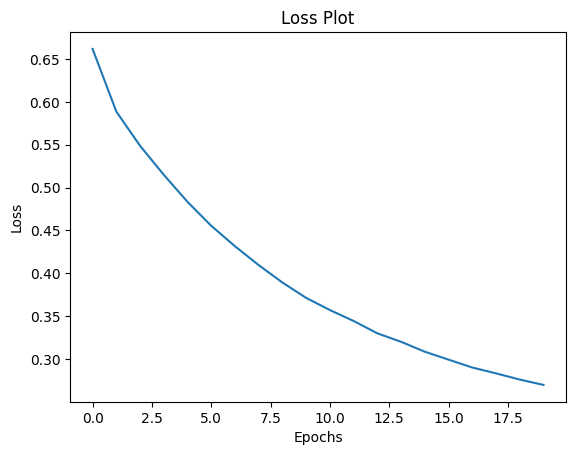

In [ ]:
train_model(encoder, decoder, ckpt_manager)

./train2014/COCO_train2014_000000314787.jpg
Real Caption: <start> a bathroom with brick walls a toilet and sink <end>
Prediction Caption: a very stylish bathroom near an <unk> pan during everything even <unk> pan position <end>


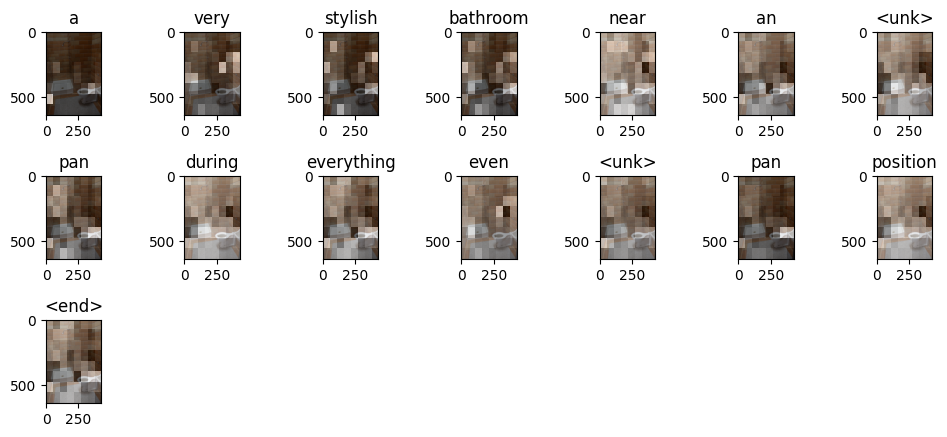

In [ ]:


# Affichage de quelques annotations dans le jeu de test
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])

result, attention_plot = evaluate(image, encoder, decoder)
    
print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

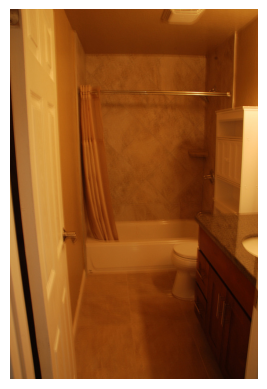


************************************************************
Predicted Caption :
a newly painted sterile bathroom with the door <end>

************************************************************
References :
<start> a white bath tub sitting next to a toilet <end>
<start> a tub and toilet in a small bathroom <end>
<start> a bathroom with some beige walls and a brown cabinet <end>
<start> a small bathroom that has a sink and a toilet <end>
<start> entrance to bathroom with shower bathtub sink with vanity and white toilet commode <end>
...

************************************************************
BLEU Score :
unigram  = 0.3977063630
bigram   = 0.2109156497
trigram  = 0.0000000000
4-gram = 0.0000000000
************************************************************


In [ ]:
display_bleu_score(image, result)

In [ ]:
# play frequency sound when training is done (linux sound)
%system paplay /usr/share/sounds/freedesktop/stereo/complete.oga

[]

In [ ]:


# Save the Encoder model
encoder.save('models/captioning_models/encoder_resnet_bilstm_model.keras')

# Save the Decoder model
decoder.save('models/captioning_models/decoder1_resnet_bilstm_model.keras')

In [ ]:
def evaluate_average_bleu(encoder, decoder, img_name_val, cap_val, tokenizer):
    total_bleu_1 = 0
    total_bleu_2 = 0
    total_bleu_3 = 0
    total_bleu_4 = 0
    num_samples = len(img_name_val)
    
    for i in range(num_samples):
        image = img_name_val[i]
        
        # Get real caption
        real_caption = [[tokenizer.index_word.get(idx, '<unk>') for idx in cap_val[i] if idx not in [0]]]
        
        # Get the predicted caption
        result, _ = evaluate(image, encoder, decoder)
        
        # Convert result into format for BLEU score
        result_caption = [result]
        
        # Calculate BLEU scores
        bleu_1 = corpus_bleu(real_caption, result_caption, weights=(1.0, 0, 0, 0))
        bleu_2 = corpus_bleu(real_caption, result_caption, weights=(0.5, 0.5, 0, 0))
        bleu_3 = corpus_bleu(real_caption, result_caption, weights=(0.33, 0.33, 0.33, 0))
        bleu_4 = corpus_bleu(real_caption, result_caption, weights=(0.25, 0.25, 0.25, 0.25))
        
        # Accumulate BLEU scores
        total_bleu_1 += bleu_1
        total_bleu_2 += bleu_2
        total_bleu_3 += bleu_3
        total_bleu_4 += bleu_4
        
        # Optional: print progress every 500 images
        if i % 500 == 0:
            print(f"Processed {i}/{num_samples} images")

    # Calculate the average BLEU score for each n-gram
    avg_bleu_1 = total_bleu_1 / num_samples
    avg_bleu_2 = total_bleu_2 / num_samples
    avg_bleu_3 = total_bleu_3 / num_samples
    avg_bleu_4 = total_bleu_4 / num_samples

    # Print the average BLEU scores
    print("\n" + "*" * 60)
    print(f"Average BLEU Score on Validation Dataset:")
    print(f"unigram  = {avg_bleu_1:.10f}")
    print(f"bigram   = {avg_bleu_2:.10f}")
    print(f"trigram  = {avg_bleu_3:.10f}")
    print(f"4-gram = {avg_bleu_4:.10f}")
    print("*" * 60)
    
    return avg_bleu_1, avg_bleu_2, avg_bleu_3, avg_bleu_4


In [ ]:
# Evaluate the model on the validation dataset
evaluate_average_bleu(encoder, decoder, img_name_val, cap_val, tokenizer)
#

Processed 0/5003 images
Processed 500/5003 images
Processed 1000/5003 images
Processed 1500/5003 images
Processed 2000/5003 images
Processed 2500/5003 images
Processed 3000/5003 images
Processed 3500/5003 images
Processed 4000/5003 images
Processed 4500/5003 images
Processed 5000/5003 images

************************************************************
Average BLEU Score on Validation Dataset:
unigram  = 0.0994896786
bigram   = 0.0000000000
trigram  = 0.0000000000
4-gram = 0.0000000000
************************************************************


(0.09948967855497265,
 4.364591788851547e-155,
 3.806644534300383e-204,
 9.343453754705764e-232)


 ## Model 2
Single Layer GRU with BLEU and ResNet50

In [ ]:
# Instantiate encoder and decoder
encoder_gru_resnet, decoder_gru_resnet = create_model(CNN_Encoder, RNN_Decoder_GRU, embedding_dim, units, vocab_size)

# Checkpoint setup
ckpt = tf.train.Checkpoint(encoder=encoder_gru_resnet, 
                           decoder=decoder_gru_resnet, 
                           optimizer=optimizer)
checkpoint_path = "./checkpoints/gru-attention"
ckpt_manager = tf.train.CheckpointManager(ckpt, 
                                          checkpoint_path, 
                                          max_to_keep=5)

# Resume training from last checkpoint if exists
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

Epoch 1 Batch 0 Loss 2.0964
Epoch 1 Batch 100 Loss 1.1680
Epoch 1 Batch 200 Loss 0.9441
Epoch 1 Batch 300 Loss 1.0024
Epoch 1 Batch 400 Loss 1.0602
Epoch 1 Batch 500 Loss 1.0049
Epoch 1 Batch 600 Loss 0.8326
Epoch 1 Batch 700 Loss 0.7792
Epoch 1 Batch 800 Loss 0.8974
Epoch 1 Batch 900 Loss 0.7943
Epoch 1 Batch 1000 Loss 0.9234
Epoch 1 Batch 1100 Loss 0.8752
Epoch 1 Batch 1200 Loss 0.8474


2024-10-23 19:13:16.528266: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 Loss 0.943236
Time taken for 1 epoch 234.17758750915527 sec

Epoch 2 Batch 0 Loss 1.0063
Epoch 2 Batch 100 Loss 0.9182
Epoch 2 Batch 200 Loss 0.8619
Epoch 2 Batch 300 Loss 0.7751
Epoch 2 Batch 400 Loss 0.8642
Epoch 2 Batch 500 Loss 0.8193
Epoch 2 Batch 600 Loss 0.7891
Epoch 2 Batch 700 Loss 0.7564
Epoch 2 Batch 800 Loss 0.7790
Epoch 2 Batch 900 Loss 0.6983
Epoch 2 Batch 1000 Loss 0.8320
Epoch 2 Batch 1100 Loss 0.7041
Epoch 2 Batch 1200 Loss 0.6296
Epoch 2 Loss 0.790500
Time taken for 1 epoch 176.20997762680054 sec

Epoch 3 Batch 0 Loss 0.7597
Epoch 3 Batch 100 Loss 0.7468
Epoch 3 Batch 200 Loss 0.6478
Epoch 3 Batch 300 Loss 0.7488
Epoch 3 Batch 400 Loss 0.7710
Epoch 3 Batch 500 Loss 0.6730
Epoch 3 Batch 600 Loss 0.6807
Epoch 3 Batch 700 Loss 0.6980
Epoch 3 Batch 800 Loss 0.7633
Epoch 3 Batch 900 Loss 0.6081
Epoch 3 Batch 1000 Loss 0.5709
Epoch 3 Batch 1100 Loss 0.7082
Epoch 3 Batch 1200 Loss 0.7064


2024-10-23 19:19:09.036911: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3 Loss 0.728305
Time taken for 1 epoch 176.13086009025574 sec

Epoch 4 Batch 0 Loss 0.7767
Epoch 4 Batch 100 Loss 0.7977
Epoch 4 Batch 200 Loss 0.7996
Epoch 4 Batch 300 Loss 0.6901
Epoch 4 Batch 400 Loss 0.9279
Epoch 4 Batch 500 Loss 0.6875
Epoch 4 Batch 600 Loss 0.6675
Epoch 4 Batch 700 Loss 0.6429
Epoch 4 Batch 800 Loss 0.5904
Epoch 4 Batch 900 Loss 0.7088
Epoch 4 Batch 1000 Loss 0.6508
Epoch 4 Batch 1100 Loss 0.5496
Epoch 4 Batch 1200 Loss 0.5898
Epoch 4 Loss 0.681548
Time taken for 1 epoch 176.12795042991638 sec

Epoch 5 Batch 0 Loss 0.7248
Epoch 5 Batch 100 Loss 0.5946
Epoch 5 Batch 200 Loss 0.6493
Epoch 5 Batch 300 Loss 0.6985
Epoch 5 Batch 400 Loss 0.6287
Epoch 5 Batch 500 Loss 0.6723
Epoch 5 Batch 600 Loss 0.6206
Epoch 5 Batch 700 Loss 0.6803
Epoch 5 Batch 800 Loss 0.6481
Epoch 5 Batch 900 Loss 0.5847
Epoch 5 Batch 1000 Loss 0.6799
Epoch 5 Batch 1100 Loss 0.7091
Epoch 5 Batch 1200 Loss 0.6551
Epoch 5 Loss 0.642496
Time taken for 1 epoch 175.99731302261353 sec

Epoch 6 Bat

2024-10-23 19:30:53.239752: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7 Loss 0.573152
Time taken for 1 epoch 176.04660749435425 sec

Epoch 8 Batch 0 Loss 0.6648
Epoch 8 Batch 100 Loss 0.5965
Epoch 8 Batch 200 Loss 0.5658
Epoch 8 Batch 300 Loss 0.5529
Epoch 8 Batch 400 Loss 0.6312
Epoch 8 Batch 500 Loss 0.5119
Epoch 8 Batch 600 Loss 0.4763
Epoch 8 Batch 700 Loss 0.5234
Epoch 8 Batch 800 Loss 0.5312
Epoch 8 Batch 900 Loss 0.5735
Epoch 8 Batch 1000 Loss 0.4996
Epoch 8 Batch 1100 Loss 0.5005
Epoch 8 Batch 1200 Loss 0.5560
Epoch 8 Loss 0.541674
Time taken for 1 epoch 176.0696837902069 sec

Epoch 9 Batch 0 Loss 0.5775
Epoch 9 Batch 100 Loss 0.4871
Epoch 9 Batch 200 Loss 0.5153
Epoch 9 Batch 300 Loss 0.4783
Epoch 9 Batch 400 Loss 0.4683
Epoch 9 Batch 500 Loss 0.5768
Epoch 9 Batch 600 Loss 0.4385
Epoch 9 Batch 700 Loss 0.4511
Epoch 9 Batch 800 Loss 0.5406
Epoch 9 Batch 900 Loss 0.5116
Epoch 9 Batch 1000 Loss 0.5508
Epoch 9 Batch 1100 Loss 0.4673
Epoch 9 Batch 1200 Loss 0.4499
Epoch 9 Loss 0.512716
Time taken for 1 epoch 175.94577312469482 sec

Epoch 10 Bat

2024-10-23 19:54:20.998139: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15 Loss 0.380666
Time taken for 1 epoch 175.88196086883545 sec

Epoch 16 Batch 0 Loss 0.3584
Epoch 16 Batch 100 Loss 0.3380
Epoch 16 Batch 200 Loss 0.3790
Epoch 16 Batch 300 Loss 0.4311
Epoch 16 Batch 400 Loss 0.3487
Epoch 16 Batch 500 Loss 0.3701
Epoch 16 Batch 600 Loss 0.4060
Epoch 16 Batch 700 Loss 0.3413
Epoch 16 Batch 800 Loss 0.4320
Epoch 16 Batch 900 Loss 0.3482
Epoch 16 Batch 1000 Loss 0.3454
Epoch 16 Batch 1100 Loss 0.3557
Epoch 16 Batch 1200 Loss 0.4170
Epoch 16 Loss 0.365070
Time taken for 1 epoch 176.03572297096252 sec

Epoch 17 Batch 0 Loss 0.3553
Epoch 17 Batch 100 Loss 0.3576
Epoch 17 Batch 200 Loss 0.3852
Epoch 17 Batch 300 Loss 0.3946
Epoch 17 Batch 400 Loss 0.3786
Epoch 17 Batch 500 Loss 0.3256
Epoch 17 Batch 600 Loss 0.3781
Epoch 17 Batch 700 Loss 0.3641
Epoch 17 Batch 800 Loss 0.3115
Epoch 17 Batch 900 Loss 0.3560
Epoch 17 Batch 1000 Loss 0.3803
Epoch 17 Batch 1100 Loss 0.3643
Epoch 17 Batch 1200 Loss 0.3805
Epoch 17 Loss 0.351258
Time taken for 1 epoch 175.90

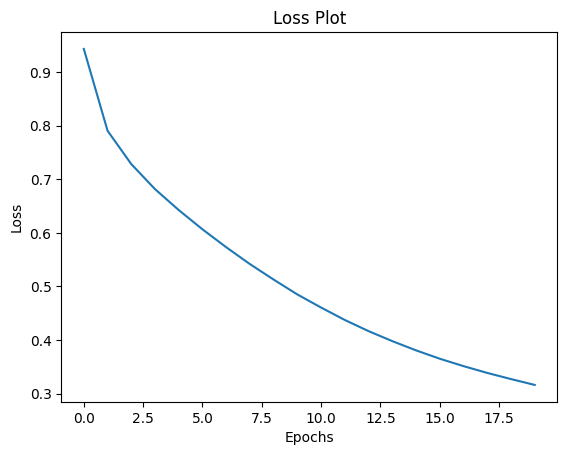

In [ ]:
train_model(encoder_gru_resnet, decoder_gru_resnet, ckpt_manager)

In [ ]:
%system paplay /usr/share/sounds/freedesktop/stereo/complete.oga

[]

./train2014/COCO_train2014_000000461189.jpg
Real Caption: <start> a kitchen with an oven and a table <end>
Prediction Caption: a view of a large kitchen with wooden cabinets and a wooden floor and black countertops counter space and white cabinets <end>


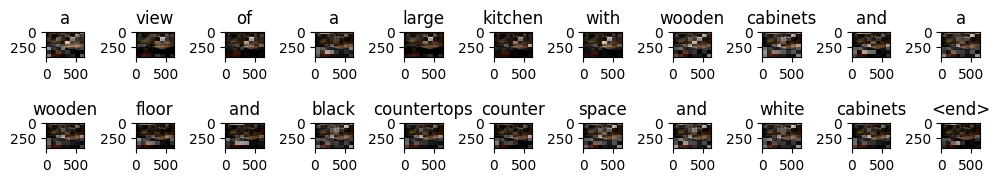

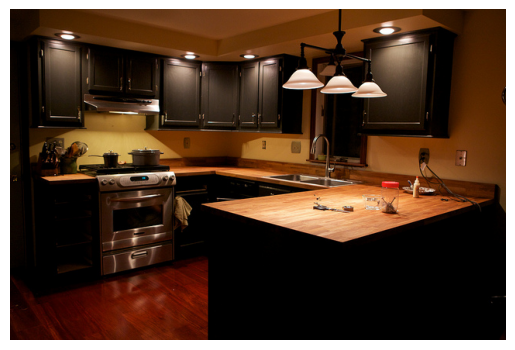


************************************************************
Predicted Caption :
a view of a large kitchen with wooden cabinets and a wooden floor and black countertops counter space and white cabinets <end>

************************************************************
References :
<start> a kitchen with an oven and a table <end>
<start> a kitchen with <unk> colored cupboards and a silver oven <end>
<start> the interior of a kitchen with multiple lighting and wood floors <end>
<start> a dimly lit kitchen with a modern dark decor <end>
<start> a large kitchen with black cabinets and silver stove <end>
...

************************************************************
BLEU Score :
unigram  = 0.4545454545
bigram   = 0.3603749851
trigram  = 0.2384833484
4-gram = 0.1616921435
************************************************************


In [ ]:

# Affichage de quelques annotations dans le jeu de test
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])

result, attention_plot = evaluate(image, encoder_gru_resnet, decoder_gru_resnet)
    
print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
display_bleu_score(image, result)

In [ ]:
encoder_gru_resnet.save('models/captioning_models/encoder_resnet_gru_model.keras')
decoder_gru_resnet.save('models/captioning_models/decoder_resnet_gru_model.keras')

In [ ]:
evaluate_average_bleu(encoder_gru_resnet, decoder_gru_resnet, img_name_val, cap_val, tokenizer)

/home/arslane/Documents/CESI/DataScience/image_captioning_full_pipeline/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/arslane/Documents/CESI/DataScience/image_captioning_full_pipeline/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/arslane/Documents/CESI/DataScience/image_captioning_full_pipeline/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gra

Processed 0/5003 images
Processed 500/5003 images
Processed 1000/5003 images
Processed 1500/5003 images
Processed 2000/5003 images
Processed 2500/5003 images
Processed 3000/5003 images
Processed 3500/5003 images
Processed 4000/5003 images
Processed 4500/5003 images
Processed 5000/5003 images

************************************************************
Average BLEU Score on Validation Dataset:
unigram  = 0.1034515997
bigram   = 0.0000000000
trigram  = 0.0000000000
4-gram = 0.0000000000
************************************************************


(0.10345159969758377,
 4.439541344333561e-155,
 3.857526580399094e-204,
 9.458452165801623e-232)


 ## Model 3
3 Layers GRU with BLEU and ResNet50

In [ ]:
# Instantiate encoder and decoder
encoder_gru_L3_resnet, decoder_gru_L3_resnet = create_model(CNN_Encoder, RNN_Decoder_GRU_3L, embedding_dim, units, vocab_size)

# Checkpoint setup
ckpt = tf.train.Checkpoint(encoder=encoder_gru_L3_resnet, 
                           decoder=decoder_gru_L3_resnet, 
                           optimizer=optimizer)
checkpoint_path = "./checkpoints/gru-l3-attention"
ckpt_manager = tf.train.CheckpointManager(ckpt, 
                                          checkpoint_path, 
                                          max_to_keep=5)

# Resume training from last checkpoint if exists
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

Epoch 1 Batch 0 Loss 1.8800
Epoch 1 Batch 100 Loss 1.3634
Epoch 1 Batch 200 Loss 1.2763
Epoch 1 Batch 300 Loss 1.2612
Epoch 1 Batch 400 Loss 1.3582
Epoch 1 Batch 500 Loss 1.4150
Epoch 1 Batch 600 Loss 1.1775
Epoch 1 Batch 700 Loss 1.3302
Epoch 1 Batch 800 Loss 1.0843
Epoch 1 Batch 900 Loss 1.1823
Epoch 1 Batch 1000 Loss 1.2612
Epoch 1 Batch 1100 Loss 1.4069
Epoch 1 Batch 1200 Loss 1.3640


2024-10-23 21:08:49.586463: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 Loss 1.275946
Time taken for 1 epoch 392.353985786438 sec

Epoch 2 Batch 0 Loss 1.4340
Epoch 2 Batch 100 Loss 1.4314
Epoch 2 Batch 200 Loss 1.0692
Epoch 2 Batch 300 Loss 1.0366
Epoch 2 Batch 400 Loss 1.0671
Epoch 2 Batch 500 Loss 0.9356
Epoch 2 Batch 600 Loss 0.9546
Epoch 2 Batch 700 Loss 0.9686
Epoch 2 Batch 800 Loss 0.9334
Epoch 2 Batch 900 Loss 0.8734
Epoch 2 Batch 1000 Loss 0.9508
Epoch 2 Batch 1100 Loss 0.9545
Epoch 2 Batch 1200 Loss 0.9678
Epoch 2 Loss 1.018137
Time taken for 1 epoch 261.60807394981384 sec

Epoch 3 Batch 0 Loss 0.8519
Epoch 3 Batch 100 Loss 0.9725
Epoch 3 Batch 200 Loss 0.7563
Epoch 3 Batch 300 Loss 0.9703
Epoch 3 Batch 400 Loss 0.9373
Epoch 3 Batch 500 Loss 0.8537
Epoch 3 Batch 600 Loss 0.8569
Epoch 3 Batch 700 Loss 0.9496
Epoch 3 Batch 800 Loss 1.0092
Epoch 3 Batch 900 Loss 0.7985
Epoch 3 Batch 1000 Loss 0.8884
Epoch 3 Batch 1100 Loss 0.7937
Epoch 3 Batch 1200 Loss 0.9104


2024-10-23 21:17:34.670808: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3 Loss 0.863571
Time taken for 1 epoch 263.3019468784332 sec

Epoch 4 Batch 0 Loss 0.7813
Epoch 4 Batch 100 Loss 0.8211
Epoch 4 Batch 200 Loss 0.7291
Epoch 4 Batch 300 Loss 0.6982
Epoch 4 Batch 400 Loss 0.9262
Epoch 4 Batch 500 Loss 0.7782
Epoch 4 Batch 600 Loss 0.7966
Epoch 4 Batch 700 Loss 0.9356
Epoch 4 Batch 800 Loss 0.7733
Epoch 4 Batch 900 Loss 0.7418
Epoch 4 Batch 1000 Loss 0.8871
Epoch 4 Batch 1100 Loss 0.7817
Epoch 4 Batch 1200 Loss 0.6912
Epoch 4 Loss 0.806589
Time taken for 1 epoch 264.0402846336365 sec

Epoch 5 Batch 0 Loss 0.8809
Epoch 5 Batch 100 Loss 0.7652
Epoch 5 Batch 200 Loss 0.8330
Epoch 5 Batch 300 Loss 0.8552
Epoch 5 Batch 400 Loss 0.8630
Epoch 5 Batch 500 Loss 0.9165
Epoch 5 Batch 600 Loss 0.6650
Epoch 5 Batch 700 Loss 0.9382
Epoch 5 Batch 800 Loss 0.7748
Epoch 5 Batch 900 Loss 0.7450
Epoch 5 Batch 1000 Loss 0.7221
Epoch 5 Batch 1100 Loss 0.6803
Epoch 5 Batch 1200 Loss 0.8076
Epoch 5 Loss 0.769270
Time taken for 1 epoch 263.58511996269226 sec

Epoch 6 Batch

2024-10-23 21:35:07.461676: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7 Loss 0.712677
Time taken for 1 epoch 262.56003999710083 sec

Epoch 8 Batch 0 Loss 0.8302
Epoch 8 Batch 100 Loss 0.7190
Epoch 8 Batch 200 Loss 0.6850
Epoch 8 Batch 300 Loss 0.6612
Epoch 8 Batch 400 Loss 0.6782
Epoch 8 Batch 500 Loss 0.7693
Epoch 8 Batch 600 Loss 0.6354
Epoch 8 Batch 700 Loss 0.7167
Epoch 8 Batch 800 Loss 0.6314
Epoch 8 Batch 900 Loss 0.7537
Epoch 8 Batch 1000 Loss 0.6188
Epoch 8 Batch 1100 Loss 0.6421
Epoch 8 Batch 1200 Loss 0.6549
Epoch 8 Loss 0.688417
Time taken for 1 epoch 263.40365076065063 sec

Epoch 9 Batch 0 Loss 0.6985
Epoch 9 Batch 100 Loss 0.7271
Epoch 9 Batch 200 Loss 0.5734
Epoch 9 Batch 300 Loss 0.5354
Epoch 9 Batch 400 Loss 0.6367
Epoch 9 Batch 500 Loss 0.6057
Epoch 9 Batch 600 Loss 0.5762
Epoch 9 Batch 700 Loss 0.6228
Epoch 9 Batch 800 Loss 0.6960
Epoch 9 Batch 900 Loss 0.7059
Epoch 9 Batch 1000 Loss 0.7739
Epoch 9 Batch 1100 Loss 0.6428
Epoch 9 Batch 1200 Loss 0.7124
Epoch 9 Loss 0.666510
Time taken for 1 epoch 261.74695348739624 sec

Epoch 10 Ba

2024-10-23 22:10:08.272078: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15 Loss 0.552805
Time taken for 1 epoch 263.6769394874573 sec

Epoch 16 Batch 0 Loss 0.5874
Epoch 16 Batch 100 Loss 0.5352
Epoch 16 Batch 200 Loss 0.6396
Epoch 16 Batch 300 Loss 0.5557
Epoch 16 Batch 400 Loss 0.5130
Epoch 16 Batch 500 Loss 0.6142
Epoch 16 Batch 600 Loss 0.5125
Epoch 16 Batch 700 Loss 0.4839
Epoch 16 Batch 800 Loss 0.4985
Epoch 16 Batch 900 Loss 0.4384
Epoch 16 Batch 1000 Loss 0.5347
Epoch 16 Batch 1100 Loss 0.5782
Epoch 16 Batch 1200 Loss 0.4964
Epoch 16 Loss 0.536064
Time taken for 1 epoch 263.8788628578186 sec

Epoch 17 Batch 0 Loss 0.5677
Epoch 17 Batch 100 Loss 0.5209
Epoch 17 Batch 200 Loss 0.5020
Epoch 17 Batch 300 Loss 0.5294
Epoch 17 Batch 400 Loss 0.5991
Epoch 17 Batch 500 Loss 0.5233
Epoch 17 Batch 600 Loss 0.4001
Epoch 17 Batch 700 Loss 0.5331
Epoch 17 Batch 800 Loss 0.4739
Epoch 17 Batch 900 Loss 0.4897
Epoch 17 Batch 1000 Loss 0.5354
Epoch 17 Batch 1100 Loss 0.4603
Epoch 17 Batch 1200 Loss 0.4435
Epoch 17 Loss 0.520028
Time taken for 1 epoch 264.1160

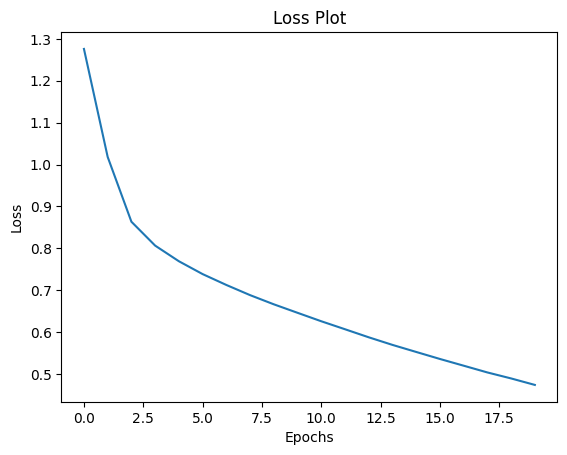

In [ ]:
train_model(encoder_gru_L3_resnet, decoder_gru_L3_resnet, ckpt_manager)

In [ ]:
%system paplay /usr/share/sounds/freedesktop/stereo/complete.oga

[]

./train2014/COCO_train2014_000000274277.jpg


W0000 00:00:1729715528.379348    9838 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729715528.380787    9838 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729715528.382240    9838 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729715528.383702    9838 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729715528.385150    9838 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729715528.386612    9838 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729715528.388053    9838 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729715528.389501    9838 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729715528.390958    9838 gp

Real Caption: <start> a small child is petting a brown cow by a fence <end>
Prediction Caption: a boy is working on a keyboard in kitchen levitating in a blender <end>


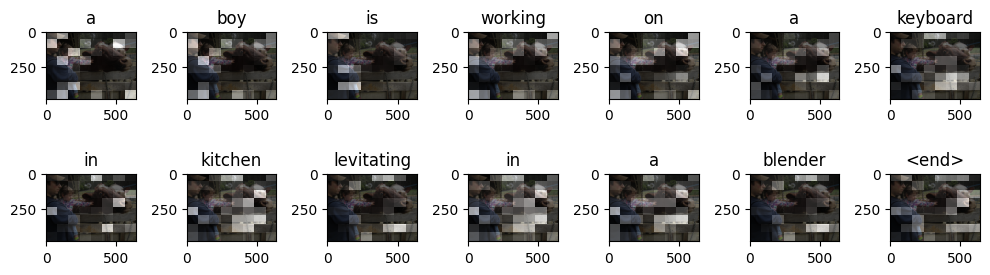

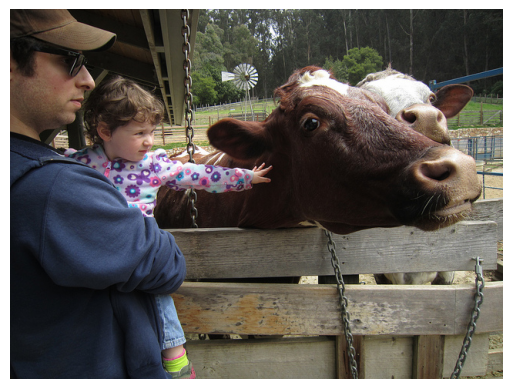


************************************************************
Predicted Caption :
a boy is working on a keyboard in kitchen levitating in a blender <end>

************************************************************
References :
<start> a small child is petting a brown cow by a fence <end>
<start> a father holds his daughter and <unk> her pet a cow <end>
<start> a young girl is reaching out to pet a large cow <end>
<start> a man holding a baby who is touching a cow <end>
<start> the young child is petting the cow at the farm <end>
...

************************************************************
BLEU Score :
unigram  = 0.3571428571
bigram   = 0.0000000000
trigram  = 0.0000000000
4-gram = 0.0000000000
************************************************************


/home/arslane/Documents/CESI/DataScience/image_captioning_full_pipeline/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/arslane/Documents/CESI/DataScience/image_captioning_full_pipeline/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/arslane/Documents/CESI/DataScience/image_captioning_full_pipeline/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gra

In [ ]:

# Affichage de quelques annotations dans le jeu de test
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])

result, attention_plot = evaluate(image, encoder_gru_L3_resnet, decoder_gru_L3_resnet)
    
print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
display_bleu_score(image, result)

In [ ]:
encoder_gru_L3_resnet.save('models/captioning_models/encoder_resnet_gru_model.keras')
decoder_gru_L3_resnet.save('models/captioning_models/decoder_resnet_gru_model.keras')

In [ ]:
evaluate_average_bleu(encoder_gru_L3_resnet, decoder_gru_L3_resnet, img_name_val, cap_val, tokenizer)

Processed 0/5003 images
Processed 500/5003 images
Processed 1000/5003 images
Processed 1500/5003 images
Processed 2000/5003 images
Processed 2500/5003 images
Processed 3000/5003 images
Processed 3500/5003 images
Processed 4000/5003 images
Processed 4500/5003 images
Processed 5000/5003 images

************************************************************
Average BLEU Score on Validation Dataset:
unigram  = 0.0972967400
bigram   = 0.0000000000
trigram  = 0.0000000000
4-gram = 0.0000000000
************************************************************


(0.09729673999997569,
 4.261733441016533e-155,
 3.7465316748112534e-204,
 9.244315369840666e-232)

In [ ]:
%system paplay /usr/share/sounds/freedesktop/stereo/complete.oga

[]

## Model 4
LSTM with BLEU and ResNet50

In [ ]:


# Instantiate encoder and decoder
encoder_lstm, decoder_lstm = create_model(CNN_Encoder, RNN_Decoder_LSTM, embedding_dim, units, vocab_size)

# Checkpoint setup
ckpt = tf.train.Checkpoint(encoder=encoder_lstm,
                           decoder=decoder_lstm,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt,
                                          checkpoint_path,
                                          max_to_keep=5)

# Resume training from last checkpoint if exists
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'kernel', 'kernel', 'bias', 'kernel'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 1 Batch 0 Loss 1.3831
Epoch 1 Batch 100 Loss 0.9723
Epoch 1 Batch 200 Loss 0.8904
Epoch 1 Batch 300 Loss 0.8751
Epoch 1 Batch 400 Loss 0.8336
Epoch 1 Batch 500 Loss 0.7832
Epoch 1 Batch 600 Loss 0.7403
Epoch 1 Loss 0.870570
Time taken for 1 epoch 152.00215911865234 sec

Epoch 2 Batch 0 Loss 0.8049
Epoch 2 Batch 100 Loss 0.8281
Epoch 2 Batch 200 Loss 0.7264
Epoch 2 Batch 300 Loss 0.6799
Epoch 2 Batch 400 Loss 0.6123
Epoch 2 Batch 500 Loss 0.7127
Epoch 2 Batch 600 Loss 0.6841
Epoch 2 Loss 0.738784
Time taken for 1 epoch 93.13927578926086 sec

Epoch 3 Batch 0 Loss 0.6805
Epoch 3 Batch 100 Loss 0.6375
Epoch 3 Batch 200 Loss 0.7164
Epoch 3 Batch 300 Loss 0.6625
Epoch 3 Batch 400 Loss 0.5675
Epoch 3 Batch 500 Loss 0.6545
Epoch 3 Batch 600 Loss 0.6307
Epoch 3 Loss 0.678108
Time taken for 1 epoch 93.11038064956665 sec

Epoch 4 Batch 0 Loss 0.7152
Epoch 4 Batch 100 Loss 0.6767
Epoch 4 Batch 200 Loss 0.6591
Epoch 4 Batch 300 Loss 0.5683
Epoch 4 Batch 400 Loss 0.6328
Epoch 4 Batch 500 Loss 

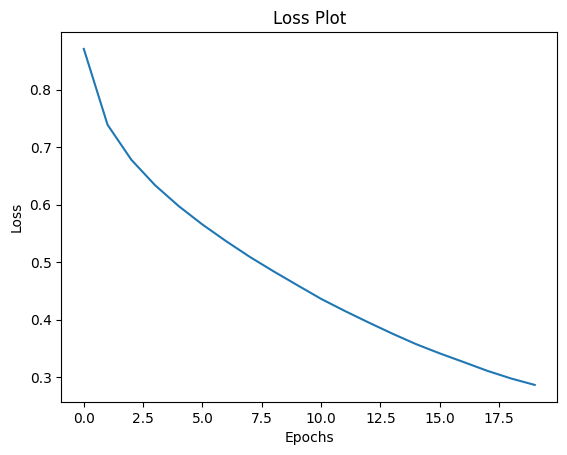

In [ ]:
train_model(encoder_lstm, decoder_lstm, ckpt_manager)

transfer_learning/train2014/COCO_train2014_000000251219.jpg
Real Caption: <start> a kitchen with a refrigerator sink and shelving with various items <end>
Prediction Caption: a kitchen with a stove sink tissue and cabinets and stove and appliances <end>


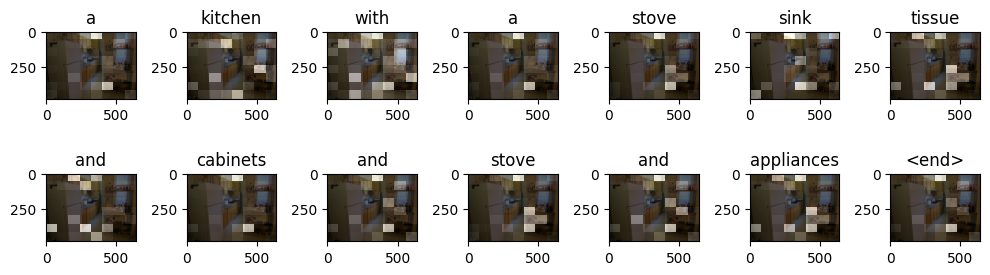

In [ ]:


# Affichage de quelques annotations dans le jeu de test
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])

result, attention_plot = evaluate(image, encoder, decoder)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

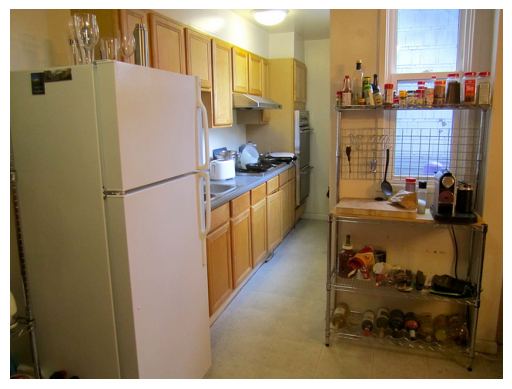


************************************************************
Predicted Caption :
a kitchen with a stove sink tissue and cabinets and stove and appliances <end>

************************************************************
References :
<start> a white refrigerator freezer sitting in a kitchen <end>
<start> a white refrigerator that is in a kitchen <end>
<start> a photo of household kitchen with a traditional look <end>
<start> a modest kitchen with wooden cabinets and a spice shelf <end>
<start> a kitchen with a refrigerator sink and shelving with various items <end>
...

************************************************************
BLEU Score :
unigram  = 0.5714285714
bigram   = 0.4193139347
trigram  = 0.3119507414
4-gram = 0.2271870978
************************************************************


In [ ]:


display_bleu_score(image, result)

In [ ]:


# Save the Encoder model
encoder.save('models/captioning_models/encoder_lstm_resnet.keras')

# Save the Decoder model
decoder.save('models/captioning_models/decoder_lstm_resnet.keras')

In [ ]:
evaluate_average_bleu(encoder, decoder, img_name_val, cap_val, tokenizer)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Processed 0/5003 images
Processed 500/5003 images
Processed 1000/5003 images
Processed 1500/5003 images
Processed 2000/5003 images
Processed 2500/5003 images
Processed 3000/5003 images
Processed 3500/5003 images
Processed 4000/5003 images
Processed 4500/5003 images
Processed 5000/5003 images

************************************************************
Average BLEU Score on Validation Dataset:
unigram  = 0.1137287452
bigram   = 0.0000209531
trigram  = 0.0000000000
4-gram = 0.0000000000
************************************************************


(0.11372874523877911,
 2.0953124859522655e-05,
 1.345579927627796e-106,
 9.653423620941904e-159)


 ## Model 5
3 Layers GRU with BLEU and InceptionV3

In [ ]:
# Instantiate encoder and decoder
encoder_gru_L3_incv3, decoder_gru_L3_incv3 = create_model(CNN_Encoder, RNN_Decoder_GRU_3L, embedding_dim, units, vocab_size)

# Checkpoint setup
ckpt = tf.train.Checkpoint(encoder=encoder_gru_L3_incv3, 
                           decoder=decoder_gru_L3_incv3, 
                           optimizer=optimizer)
checkpoint_path = "./checkpoints/gru-l3-incv3"
ckpt_manager = tf.train.CheckpointManager(ckpt, 
                                          checkpoint_path, 
                                          max_to_keep=5)

# Resume training from last checkpoint if exists
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

Epoch 1 Batch 0 Loss 2.0273
Epoch 1 Batch 100 Loss 1.4244
Epoch 1 Batch 200 Loss 1.0996
Epoch 1 Batch 300 Loss 1.0915
Epoch 1 Batch 400 Loss 1.0891
Epoch 1 Batch 500 Loss 1.0066
Epoch 1 Batch 600 Loss 0.9345
Epoch 1 Batch 700 Loss 0.9635
Epoch 1 Batch 800 Loss 0.9110
Epoch 1 Batch 900 Loss 0.7981
Epoch 1 Batch 1000 Loss 0.8036
Epoch 1 Batch 1100 Loss 0.8040
Epoch 1 Batch 1200 Loss 0.8165


2024-10-24 10:06:07.386889: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 Loss 0.992230
Time taken for 1 epoch 403.0873613357544 sec

Epoch 2 Batch 0 Loss 0.8655
Epoch 2 Batch 100 Loss 0.8208
Epoch 2 Batch 200 Loss 0.8260
Epoch 2 Batch 300 Loss 0.8338
Epoch 2 Batch 400 Loss 0.9222
Epoch 2 Batch 500 Loss 0.7434
Epoch 2 Batch 600 Loss 0.8859
Epoch 2 Batch 700 Loss 0.7581
Epoch 2 Batch 800 Loss 0.7558
Epoch 2 Batch 900 Loss 0.9581
Epoch 2 Batch 1000 Loss 0.7948
Epoch 2 Batch 1100 Loss 0.6928
Epoch 2 Batch 1200 Loss 0.6924
Epoch 2 Loss 0.818949
Time taken for 1 epoch 269.3762722015381 sec

Epoch 3 Batch 0 Loss 0.8814
Epoch 3 Batch 100 Loss 0.7610
Epoch 3 Batch 200 Loss 0.7679
Epoch 3 Batch 300 Loss 0.7000
Epoch 3 Batch 400 Loss 0.7909
Epoch 3 Batch 500 Loss 0.8011
Epoch 3 Batch 600 Loss 0.8097
Epoch 3 Batch 700 Loss 0.9529
Epoch 3 Batch 800 Loss 0.7974
Epoch 3 Batch 900 Loss 0.8413
Epoch 3 Batch 1000 Loss 0.6295
Epoch 3 Batch 1100 Loss 0.6649
Epoch 3 Batch 1200 Loss 0.7107


2024-10-24 10:15:05.612939: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3 Loss 0.763228
Time taken for 1 epoch 268.65580010414124 sec

Epoch 4 Batch 0 Loss 0.8183
Epoch 4 Batch 100 Loss 0.7115
Epoch 4 Batch 200 Loss 0.5065
Epoch 4 Batch 300 Loss 0.7208
Epoch 4 Batch 400 Loss 0.7995
Epoch 4 Batch 500 Loss 0.8565
Epoch 4 Batch 600 Loss 0.6849
Epoch 4 Batch 700 Loss 0.7132
Epoch 4 Batch 800 Loss 0.6334
Epoch 4 Batch 900 Loss 0.6796
Epoch 4 Batch 1000 Loss 0.7184
Epoch 4 Batch 1100 Loss 0.6818
Epoch 4 Batch 1200 Loss 0.6700
Epoch 4 Loss 0.727730
Time taken for 1 epoch 269.0176486968994 sec

Epoch 5 Batch 0 Loss 0.7593
Epoch 5 Batch 100 Loss 0.7043
Epoch 5 Batch 200 Loss 0.6963
Epoch 5 Batch 300 Loss 0.7011
Epoch 5 Batch 400 Loss 0.7265
Epoch 5 Batch 500 Loss 0.6103
Epoch 5 Batch 600 Loss 0.8109
Epoch 5 Batch 700 Loss 0.6947
Epoch 5 Batch 800 Loss 0.6715
Epoch 5 Batch 900 Loss 0.5703
Epoch 5 Batch 1000 Loss 0.6739
Epoch 5 Batch 1100 Loss 0.5613
Epoch 5 Batch 1200 Loss 0.5914
Epoch 5 Loss 0.700923
Time taken for 1 epoch 270.2045750617981 sec

Epoch 6 Batch

2024-10-24 10:33:03.323824: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7 Loss 0.650628
Time taken for 1 epoch 268.11972188949585 sec

Epoch 8 Batch 0 Loss 0.6282
Epoch 8 Batch 100 Loss 0.6848
Epoch 8 Batch 200 Loss 0.6740
Epoch 8 Batch 300 Loss 0.5582
Epoch 8 Batch 400 Loss 0.5874
Epoch 8 Batch 500 Loss 0.6132
Epoch 8 Batch 600 Loss 0.6987
Epoch 8 Batch 700 Loss 0.6518
Epoch 8 Batch 800 Loss 0.5698
Epoch 8 Batch 900 Loss 0.6209
Epoch 8 Batch 1000 Loss 0.6382
Epoch 8 Batch 1100 Loss 0.5934
Epoch 8 Batch 1200 Loss 0.4897
Epoch 8 Loss 0.625871
Time taken for 1 epoch 269.6277639865875 sec

Epoch 9 Batch 0 Loss 0.5534
Epoch 9 Batch 100 Loss 0.6635
Epoch 9 Batch 200 Loss 0.7824
Epoch 9 Batch 300 Loss 0.7120
Epoch 9 Batch 400 Loss 0.5911
Epoch 9 Batch 500 Loss 0.5887
Epoch 9 Batch 600 Loss 0.5511
Epoch 9 Batch 700 Loss 0.5679
Epoch 9 Batch 800 Loss 0.4577
Epoch 9 Batch 900 Loss 0.5216
Epoch 9 Batch 1000 Loss 0.5345
Epoch 9 Batch 1100 Loss 0.5544
Epoch 9 Batch 1200 Loss 0.5633
Epoch 9 Loss 0.606553
Time taken for 1 epoch 269.325320482254 sec

Epoch 10 Batch

2024-10-24 11:08:51.620486: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15 Loss 0.484940
Time taken for 1 epoch 268.5790066719055 sec

Epoch 16 Batch 0 Loss 0.4544
Epoch 16 Batch 100 Loss 0.4405
Epoch 16 Batch 200 Loss 0.5063
Epoch 16 Batch 300 Loss 0.4461
Epoch 16 Batch 400 Loss 0.4816
Epoch 16 Batch 500 Loss 0.4430
Epoch 16 Batch 600 Loss 0.4726
Epoch 16 Batch 700 Loss 0.4879
Epoch 16 Batch 800 Loss 0.4485
Epoch 16 Batch 900 Loss 0.4748
Epoch 16 Batch 1000 Loss 0.4308
Epoch 16 Batch 1100 Loss 0.5551
Epoch 16 Batch 1200 Loss 0.4556
Epoch 16 Loss 0.472030
Time taken for 1 epoch 268.04731154441833 sec

Epoch 17 Batch 0 Loss 0.4523
Epoch 17 Batch 100 Loss 0.4665
Epoch 17 Batch 200 Loss 0.5285
Epoch 17 Batch 300 Loss 0.4544
Epoch 17 Batch 400 Loss 0.4492
Epoch 17 Batch 500 Loss 0.5061
Epoch 17 Batch 600 Loss 0.4172
Epoch 17 Batch 700 Loss 0.5060
Epoch 17 Batch 800 Loss 0.4197
Epoch 17 Batch 900 Loss 0.4326
Epoch 17 Batch 1000 Loss 0.4764
Epoch 17 Batch 1100 Loss 0.4239
Epoch 17 Batch 1200 Loss 0.4864
Epoch 17 Loss 0.453266
Time taken for 1 epoch 267.476

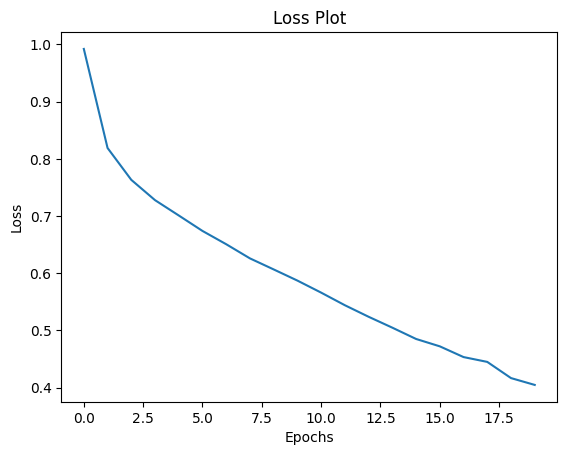

In [ ]:
train_model(encoder_gru_L3_incv3, decoder_gru_L3_incv3, ckpt_manager)

In [ ]:
%system paplay /usr/share/sounds/freedesktop/stereo/complete.oga

[]

./train2014/COCO_train2014_000000208956.jpg


W0000 00:00:1729762273.326213    9183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729762273.331408    9183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729762273.332728    9183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729762273.334061    9183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729762273.335404    9183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729762273.336757    9183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729762273.338166    9183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729762273.339525    9183 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729762273.340884    9183 gp

Real Caption: <start> a kitchen with a lot of cabinet space and a tile wall <end>
Prediction Caption: some modern looking kitchen with an oven and a window <end>


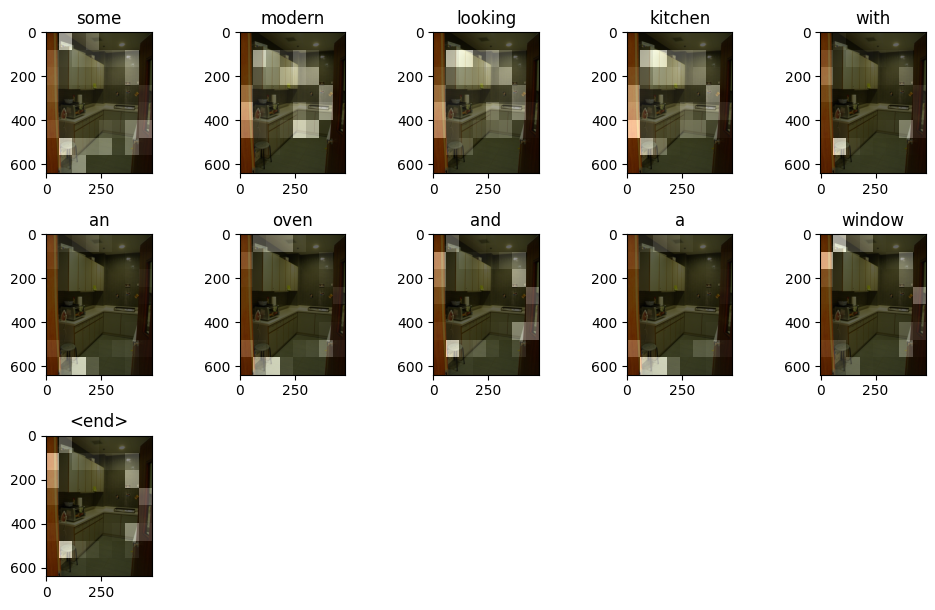

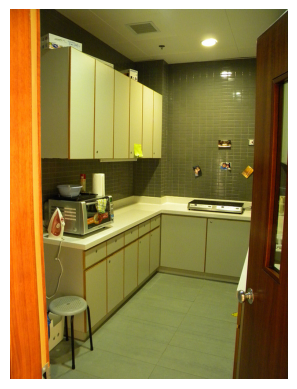


************************************************************
Predicted Caption :
some modern looking kitchen with an oven and a window <end>

************************************************************
References :
<start> a room showing a kitchen with a microwave and a cooker <end>
<start> the lights are on in the kitchen with white cabinets <end>
<start> a small kitchen showing counter cabinets and sink <end>
<start> a kitchen with a lot of cabinet space and a tile wall <end>
<start> a look in to a very typical looking kitchen with white cabinets <end>
...

************************************************************
BLEU Score :
unigram  = 0.5454545455
bigram   = 0.4045199175
trigram  = 0.2664896292
4-gram = 0.0000000000
************************************************************


/home/arslane/Documents/CESI/DataScience/image_captioning_full_pipeline/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [ ]:

# Affichage de quelques annotations dans le jeu de test
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])

result, attention_plot = evaluate(image, encoder_gru_L3_incv3, decoder_gru_L3_incv3)
    
print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
display_bleu_score(image, result)

In [ ]:


# Optimizer and Checkpoint Management
checkpoint_path = "./checkpoints/lstm-incv3"


 ## Model 6
 LSTM and InceptionV3

In [ ]:


# Instantiate encoder and decoder
encoder_lstm_incv3, decoder_lstm_incv3 = create_model(CNN_Encoder, RNN_Decoder_LSTM, embedding_dim, units, vocab_size)

# Checkpoint setup
ckpt = tf.train.Checkpoint(encoder=encoder_lstm_incv3,
                           decoder=decoder_lstm_incv3,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt,
                                          checkpoint_path,
                                          max_to_keep=5)

# Resume training from last checkpoint if exists
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

Epoch 1 Batch 0 Loss 1.9984
Epoch 1 Batch 100 Loss 1.1119
Epoch 1 Batch 200 Loss 1.0133
Epoch 1 Batch 300 Loss 0.9281
Epoch 1 Batch 400 Loss 0.8589
Epoch 1 Batch 500 Loss 0.7671
Epoch 1 Batch 600 Loss 0.8167
Epoch 1 Loss 0.991312
Time taken for 1 epoch 129.95868301391602 sec

Epoch 2 Batch 0 Loss 0.9500
Epoch 2 Batch 100 Loss 0.7699
Epoch 2 Batch 200 Loss 0.8934
Epoch 2 Batch 300 Loss 0.7875
Epoch 2 Batch 400 Loss 0.7850
Epoch 2 Batch 500 Loss 0.7493
Epoch 2 Batch 600 Loss 0.7019
Epoch 2 Loss 0.800343
Time taken for 1 epoch 77.09135317802429 sec

Epoch 3 Batch 0 Loss 0.7677
Epoch 3 Batch 100 Loss 0.7789
Epoch 3 Batch 200 Loss 0.7544
Epoch 3 Batch 300 Loss 0.7827
Epoch 3 Batch 400 Loss 0.7102
Epoch 3 Batch 500 Loss 0.7426
Epoch 3 Batch 600 Loss 0.7239
Epoch 3 Loss 0.727023
Time taken for 1 epoch 76.90206217765808 sec

Epoch 4 Batch 0 Loss 0.8144
Epoch 4 Batch 100 Loss 0.7971
Epoch 4 Batch 200 Loss 0.7578
Epoch 4 Batch 300 Loss 0.6326
Epoch 4 Batch 400 Loss 0.6539
Epoch 4 Batch 500 Loss 

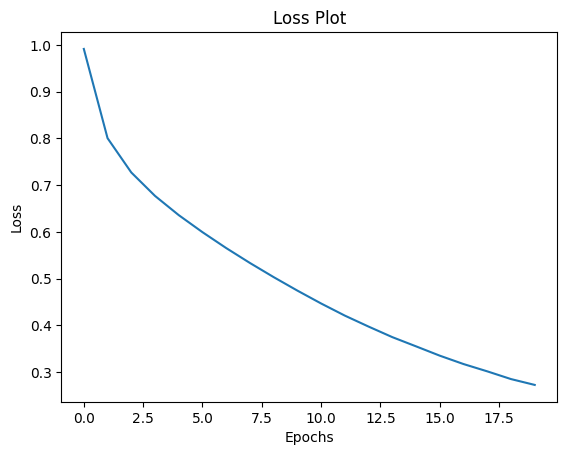

In [ ]:
train_model(encoder_lstm_incv3, decoder_lstm_incv3, ckpt_manager)

/kaggle/working/train2014/COCO_train2014_000000199598.jpg
Real Caption: <start> this is a very large bathroom in an empty house <end>
Prediction Caption: a bathroom with a large mirror and a light on <end>


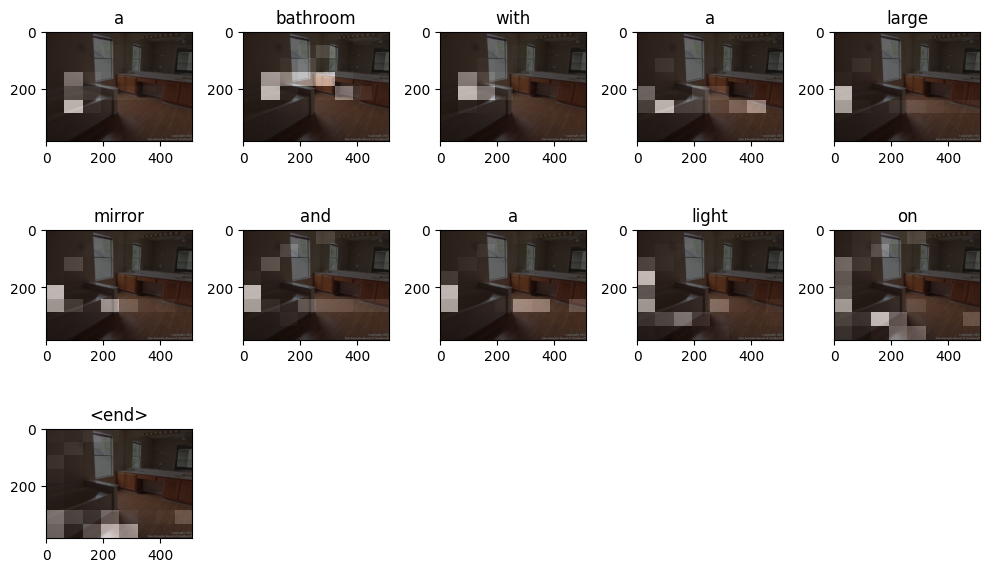

In [ ]:


# Affichage de quelques annotations dans le jeu de test
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])

result, attention_plot = evaluate(image, encoder_lstm_incv3, decoder_lstm_incv3)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

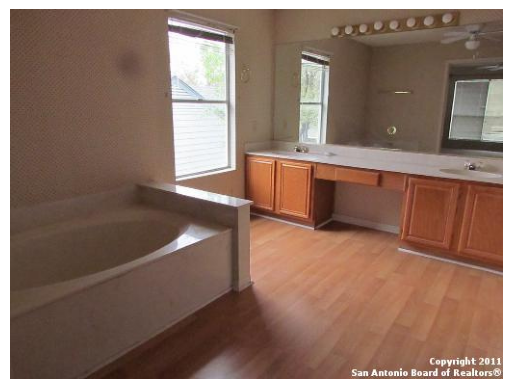


************************************************************
Predicted Caption :
a bathroom with a large mirror and a light on <end>

************************************************************
References :
<start> this an empty master bathroom of a vacant house <end>
<start> a bathroom with a large white tub next to a window <end>
<start> a bath tub sits in a large bathroom <end>
<start> a view of a large bathroom with a huge tub in it <end>
<start> this is a very large bathroom in an empty house <end>
...

************************************************************
BLEU Score :
unigram  = 0.6363636364
bigram   = 0.5045249791
trigram  = 0.4430498054
4-gram = 0.3816330911
************************************************************


In [ ]:
display_bleu_score(image, result)

In [ ]:


# Save the Encoder model
encoder_lstm_incv3.save('/kaggle/working/models/captioning_models/encoder_lstm_incv3.keras')

# Save the Decoder model
decoder_lstm_incv3.save('/kaggle/working/models/captioning_models/decoder_lstm_incv3.keras')

In [ ]:
evaluate_average_bleu(encoder_lstm_incv3, decoder_lstm_incv3, img_name_val, cap_val, tokenizer)

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Processed 0/5003 images
Processed 500/5003 images
Processed 1000/5003 images
Processed 1500/5003 images
Processed 2000/5003 images
Processed 2500/5003 images
Processed 3000/5003 images
Processed 3500/5003 images
Processed 4000/5003 images
Processed 4500/5003 images
Processed 5000/5003 images

************************************************************
Average BLEU Score on Validation Dataset:
unigram  = 0.0914357750
bigram   = 0.2912023558
trigram  = 0.4352421055
4-gram = 0.5266112327
************************************************************


(0.09143577502154202,
 0.29120235581086157,
 0.4352421054856086,
 0.5266112326833678)

In [ ]:
encoder_gru_L3_incv3.save('models/captioning_models/encoder_IncV3_gru_model.keras')
decoder_gru_L3_incv3.save('models/captioning_models/decoder_IncV3_gru_model.keras')

In [ ]:
evaluate_average_bleu(encoder_gru_L3_incv3, decoder_gru_L3_incv3, img_name_val, cap_val, tokenizer)

/home/arslane/Documents/CESI/DataScience/image_captioning_full_pipeline/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/arslane/Documents/CESI/DataScience/image_captioning_full_pipeline/.venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Processed 0/5003 images
Processed 500/5003 images
Processed 1000/5003 images
Processed 1500/5003 images
Processed 2000/5003 images
Processed 2500/5003 images
Processed 3000/5003 images
Processed 3500/5003 images
Processed 4000/5003 images
Processed 4500/5003 images
Processed 5000/5003 images

************************************************************
Average BLEU Score on Validation Dataset:
unigram  = 0.1000155120
bigram   = 0.0000000000
trigram  = 0.0000000000
4-gram = 0.0000000000
************************************************************


(0.10001551200368086,
 4.456034186751795e-155,
 3.901438391495613e-204,
 9.59098435557862e-232)

In [ ]:
%system paplay /usr/share/sounds/freedesktop/stereo/complete.oga

[]


## Model 7
LSTM with BLEU and InceptionV3

In [ ]:


# Optimizer and Checkpoint Management
checkpoint_path = "./checkpoints/lstm-incv3"

In [ ]:


# Instantiate encoder and decoder
encoder_lstm_incv3, decoder_lstm_incv3 = create_model(CNN_Encoder, RNN_Decoder_LSTM, embedding_dim, units, vocab_size)

# Checkpoint setup
ckpt = tf.train.Checkpoint(encoder=encoder_lstm_incv3,
                           decoder=decoder_lstm_incv3,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt,
                                          checkpoint_path,
                                          max_to_keep=5)

# Resume training from last checkpoint if exists
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

Epoch 1 Batch 0 Loss 1.9984
Epoch 1 Batch 100 Loss 1.1119
Epoch 1 Batch 200 Loss 1.0133
Epoch 1 Batch 300 Loss 0.9281
Epoch 1 Batch 400 Loss 0.8589
Epoch 1 Batch 500 Loss 0.7671
Epoch 1 Batch 600 Loss 0.8167
Epoch 1 Loss 0.991312
Time taken for 1 epoch 129.95868301391602 sec

Epoch 2 Batch 0 Loss 0.9500
Epoch 2 Batch 100 Loss 0.7699
Epoch 2 Batch 200 Loss 0.8934
Epoch 2 Batch 300 Loss 0.7875
Epoch 2 Batch 400 Loss 0.7850
Epoch 2 Batch 500 Loss 0.7493
Epoch 2 Batch 600 Loss 0.7019
Epoch 2 Loss 0.800343
Time taken for 1 epoch 77.09135317802429 sec

Epoch 3 Batch 0 Loss 0.7677
Epoch 3 Batch 100 Loss 0.7789
Epoch 3 Batch 200 Loss 0.7544
Epoch 3 Batch 300 Loss 0.7827
Epoch 3 Batch 400 Loss 0.7102
Epoch 3 Batch 500 Loss 0.7426
Epoch 3 Batch 600 Loss 0.7239
Epoch 3 Loss 0.727023
Time taken for 1 epoch 76.90206217765808 sec

Epoch 4 Batch 0 Loss 0.8144
Epoch 4 Batch 100 Loss 0.7971
Epoch 4 Batch 200 Loss 0.7578
Epoch 4 Batch 300 Loss 0.6326
Epoch 4 Batch 400 Loss 0.6539
Epoch 4 Batch 500 Loss 

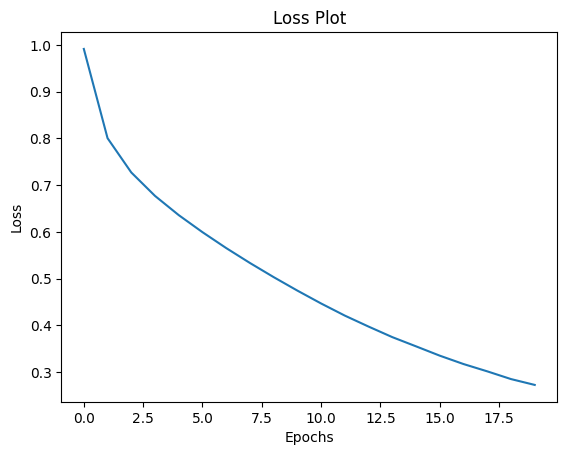

In [ ]:
train_model(encoder_lstm_incv3, decoder_lstm_incv3, ckpt_manager)

/kaggle/working/train2014/COCO_train2014_000000199598.jpg
Real Caption: <start> this is a very large bathroom in an empty house <end>
Prediction Caption: a bathroom with a large mirror and a light on <end>


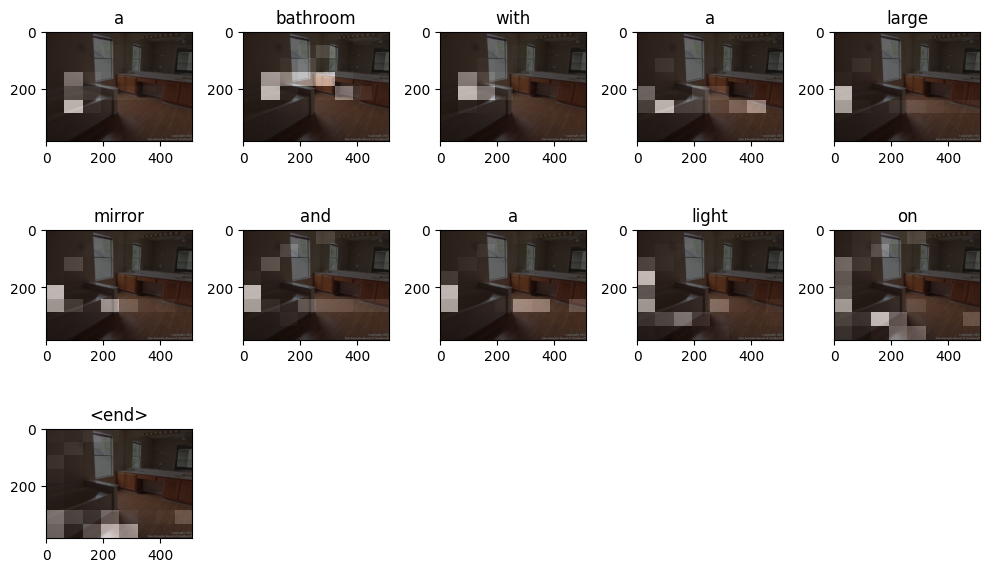

In [ ]:


# Affichage de quelques annotations dans le jeu de test
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])

result, attention_plot = evaluate(image, encoder_lstm_incv3, decoder_lstm_incv3)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

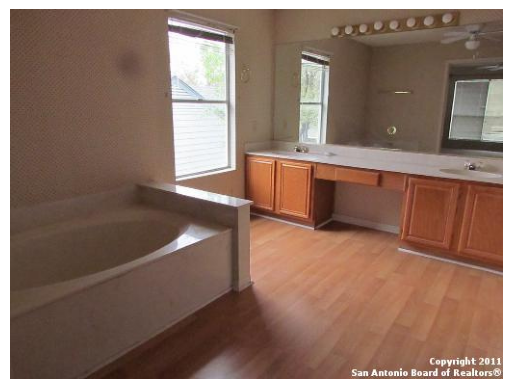


************************************************************
Predicted Caption :
a bathroom with a large mirror and a light on <end>

************************************************************
References :
<start> this an empty master bathroom of a vacant house <end>
<start> a bathroom with a large white tub next to a window <end>
<start> a bath tub sits in a large bathroom <end>
<start> a view of a large bathroom with a huge tub in it <end>
<start> this is a very large bathroom in an empty house <end>
...

************************************************************
BLEU Score :
unigram  = 0.6363636364
bigram   = 0.5045249791
trigram  = 0.4430498054
4-gram = 0.3816330911
************************************************************


In [ ]:
display_bleu_score(image, result)

In [ ]:


# Save the Encoder model
encoder_lstm_incv3.save('/kaggle/working/models/captioning_models/encoder_lstm_incv3.keras')

# Save the Decoder model
decoder_lstm_incv3.save('/kaggle/working/models/captioning_models/decoder_lstm_incv3.keras')

In [ ]:
evaluate_average_bleu(encoder_lstm_incv3, decoder_lstm_incv3, img_name_val, cap_val, tokenizer)

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Processed 0/5003 images
Processed 500/5003 images
Processed 1000/5003 images
Processed 1500/5003 images
Processed 2000/5003 images
Processed 2500/5003 images
Processed 3000/5003 images
Processed 3500/5003 images
Processed 4000/5003 images
Processed 4500/5003 images
Processed 5000/5003 images

************************************************************
Average BLEU Score on Validation Dataset:
unigram  = 0.0914357750
bigram   = 0.2912023558
trigram  = 0.4352421055
4-gram = 0.5266112327
************************************************************


(0.09143577502154202,
 0.29120235581086157,
 0.4352421054856086,
 0.5266112326833678)


 ## Model 7
GRU with BLEU and InceptionV3

In [ ]:


# Instantiate encoder and decoder
encoder_gru_incv3, decoder_gru_incv3 = create_model(CNN_Encoder, RNN_Decoder_GRU, embedding_dim, units, vocab_size)

# Checkpoint setup
ckpt = tf.train.Checkpoint(encoder=encoder_gru_incv3,
                           decoder=decoder_gru_incv3,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt,
                                          checkpoint_path,
                                          max_to_keep=5)

# Resume training from last checkpoint if exists
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

Epoch 1 Batch 0 Loss 1.8949
Epoch 1 Batch 100 Loss 0.9383
Epoch 1 Batch 200 Loss 0.7920
Epoch 1 Batch 300 Loss 0.8357
Epoch 1 Batch 400 Loss 0.7962
Epoch 1 Batch 500 Loss 0.7882
Epoch 1 Batch 600 Loss 0.6864
Epoch 1 Loss 0.850178
Time taken for 1 epoch 136.3702175617218 sec

Epoch 2 Batch 0 Loss 0.8000
Epoch 2 Batch 100 Loss 0.7817
Epoch 2 Batch 200 Loss 0.7412
Epoch 2 Batch 300 Loss 0.7135
Epoch 2 Batch 400 Loss 0.6566
Epoch 2 Batch 500 Loss 0.7199
Epoch 2 Batch 600 Loss 0.6245
Epoch 2 Loss 0.715335
Time taken for 1 epoch 67.74349689483643 sec

Epoch 3 Batch 0 Loss 0.6831
Epoch 3 Batch 100 Loss 0.6933
Epoch 3 Batch 200 Loss 0.6508
Epoch 3 Batch 300 Loss 0.6507
Epoch 3 Batch 400 Loss 0.6452
Epoch 3 Batch 500 Loss 0.6322
Epoch 3 Batch 600 Loss 0.6261
Epoch 3 Loss 0.661079
Time taken for 1 epoch 67.64078164100647 sec

Epoch 4 Batch 0 Loss 0.7098
Epoch 4 Batch 100 Loss 0.5877
Epoch 4 Batch 200 Loss 0.5796
Epoch 4 Batch 300 Loss 0.5457
Epoch 4 Batch 400 Loss 0.6382
Epoch 4 Batch 500 Loss 0

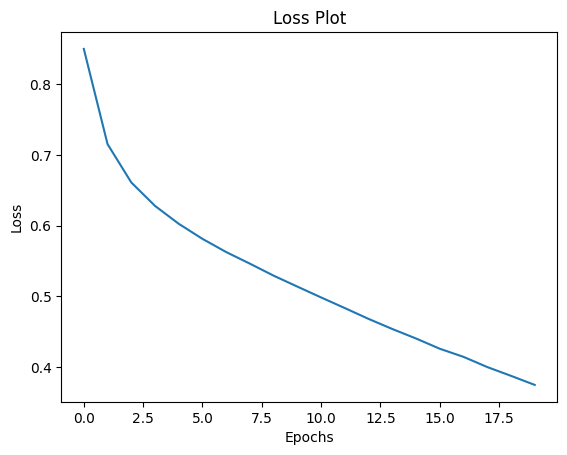

In [ ]:
train_model(encoder_gru_incv3, decoder_gru_incv3, ckpt_manager)

/kaggle/working/train2014/COCO_train2014_000000501059.jpg
Real Caption: <start> a bunch of cars parked on the side of the road <end>
Prediction Caption: a car is parked cars <end>


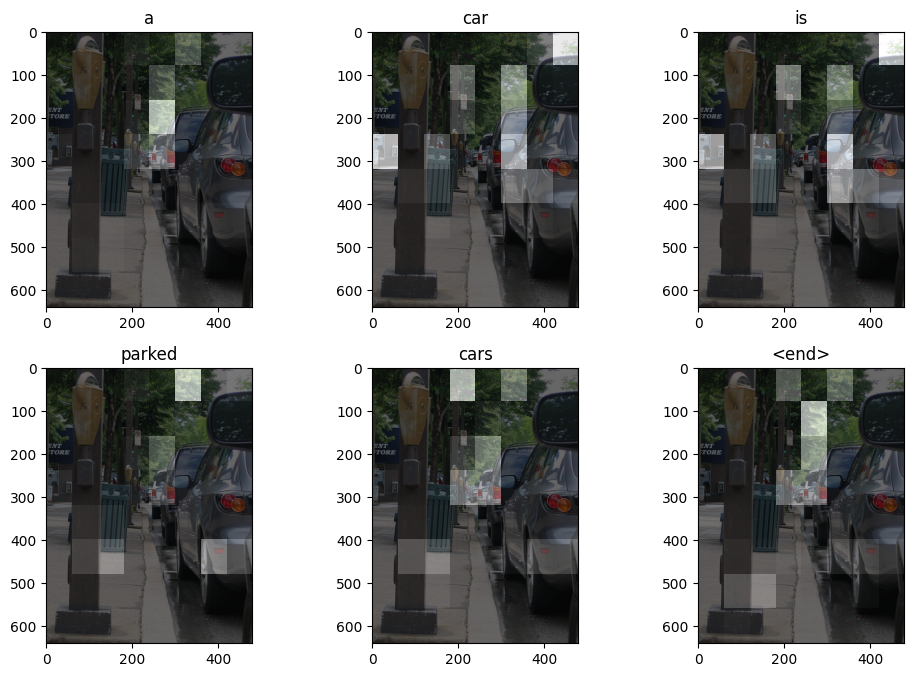

In [ ]:


# Affichage de quelques annotations dans le jeu de test
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])

result, attention_plot = evaluate(image, encoder_gru_incv3, decoder_gru_incv3)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

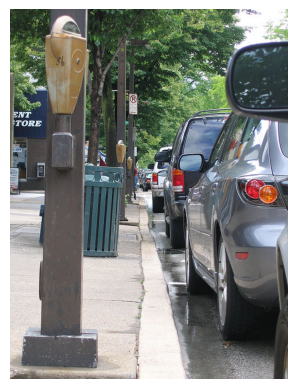


************************************************************
Predicted Caption :
a car is parked cars <end>

************************************************************
References :
<start> a parking meter on a road with cars parked nearby <end>
<start> a bunch of cars parked on the side of the road <end>
<start> a view of street from curb with cars parked on side of street rows of parking meters trash bin with trees <end>
<start> a street filled with parked cars next to parking meters <end>
<start> several cars parked on the side of the road <end>
...

************************************************************
BLEU Score :
unigram  = 0.2897321390
bigram   = 0.1586928282
trigram  = 0.2235206825
4-gram = 0.2626168670
************************************************************


In [ ]:
display_bleu_score(image, result)

In [ ]:


# Save the Encoder model
encoder_gru_incv3.save('models/captioning_models/encoder_gru_incv3.keras')

# Save the Decoder model
decoder_gru_incv3.save('models/captioning_models/decoder_gru_incv3.keras')

In [ ]:
evaluate_average_bleu(encoder_gru_incv3, decoder_gru_incv3, img_name_val, cap_val, tokenizer)

Processed 0/5003 images
Processed 500/5003 images
Processed 1000/5003 images
Processed 1500/5003 images
Processed 2000/5003 images
Processed 2500/5003 images
Processed 3000/5003 images
Processed 3500/5003 images
Processed 4000/5003 images
Processed 4500/5003 images
Processed 5000/5003 images

************************************************************
Average BLEU Score on Validation Dataset:
unigram  = 0.0912703781
bigram   = 0.2830066358
trigram  = 0.4199234109
4-gram = 0.5064984794
************************************************************


(0.0912703780917766, 0.28300663576604557, 0.41992341086909, 0.5064984794036137)

In [67]:
from CaptioningClasses import CNN_Encoder, BahdanauAttention, RNN_Decoder_LSTM
from keras.models import load_model

# load lstm model from weights
encoder_lstm = CNN_Encoder(embedding_dim)
decoder_lstm = RNN_Decoder_LSTM(embedding_dim, units, vocab_size)
encoder_lstm.load_weights('models/captioning_models/encoderfinal.weights.h5')
decoder_lstm.load_weights('models/captioning_models/decoderfinal.weights.h5')
encoder_lstm.compile()
decoder_lstm.compile()


./train2014/COCO_train2014_000000446813.jpg
Real Caption: <start> a city street lined with buildings and street lights <end>
Prediction Caption: upward browse pink smoking bouquet new stirs nicley lined queuing silhouettes upward windmills lving ale back wheelchair tattered warrior protestors crumpled hall hanging flowering th row right overhead taxis closet vintage blanket carry upscale treat sparkles banner across blade means fry drinking wit adding masking together parade


/tmp/ipykernel_5123/3611549005.py:97: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


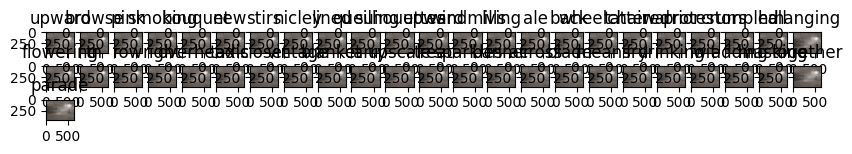

In [68]:
# Affichage de quelques annotations dans le jeu de test
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])

result, attention_plot = evaluate(image, encoder_lstm, decoder_lstm)
    
print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

/home/arslane/Documents/CESI/DataScience/image_captioning_full_pipeline/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/arslane/Documents/CESI/DataScience/image_captioning_full_pipeline/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'decoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


W0000 00:00:1729781776.706578   47091 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729781776.708023   47091 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729781776.709418   47091 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729781776.710852   47091 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729781776.712287   47091 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729781776.713714   47091 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729781776.715135   47091 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729781776.716541   47091 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729781776.717937   47091 gp

Initial class: 1
is photo


I0000 00:00:1729781776.960709   47089 service.cc:146] XLA service 0x653fe32aeb30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729781776.960725   47089 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2024-10-24 16:56:16.967708: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Initial class: 1
is photo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Initial class: 0
not photo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


I0000 00:00:1729781777.834386   47089 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
reclassified as not photo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Initial class: 1
is photo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Initial class: 0
not photo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
reclassified as photo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Initial class: 1
is photo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Initial class: 1
is photo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Initial class: 1
is photo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Initial class: 1
is photo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Initial class: 1
is photo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Initial class: 1
is photo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Initial class: 1
is p

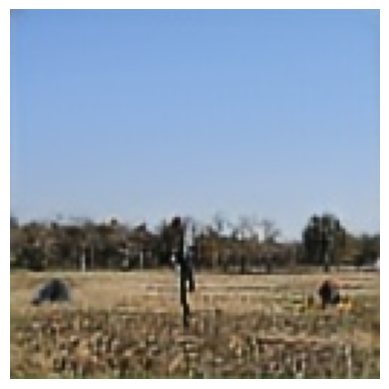

Caption: towards disagreement recipe spices makeup rather general recording quote toward foreign calm win carpeted cigarette wood closet pot better ground oven wines european wire doughnut bites family groom portrait remotes swinging slate adorn roller believing cloud guy prevalent painting treats placidly mountainous cabinet accent decorating cast spartan


Image: ./processed_images/processed_image_80.jpg


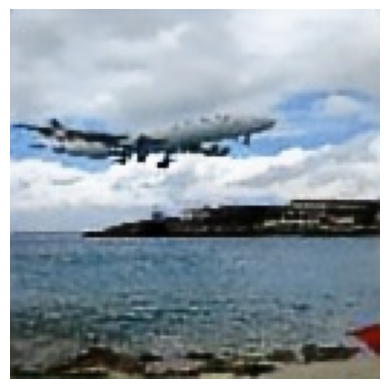

Caption: rail
 coming bad goldfish smiles efficient sprinkles auto converse knife powered pair rusty kisses en seeds planes amphitheater items smaller exposed cheese muzzle snowing skills partial surboard repair connected jackets two lifted military smirks drier motel real pale farming parasol aluminum most skillets simply flashing capture loaf


Image: ./processed_images/processed_image_44.jpg


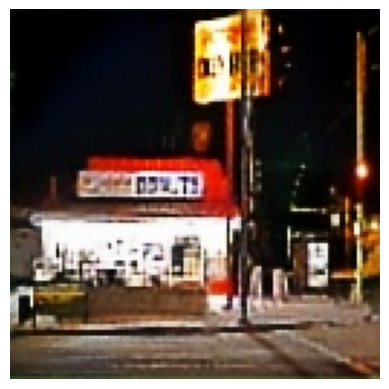

Caption: kithceh game furnishings wand ski catchup pitcher leaping curiously removable patterns doge stiring rests clearly extensive featuring scalloped types rickshaw countryside exactly act magnets role para puppet flatbed painted sings spoons twelve leafy cookstove poster ornately faces shell affixed shines harsh appliance fancy bars clad sticks protestors


Image: ./processed_images/processed_image_7.jpg


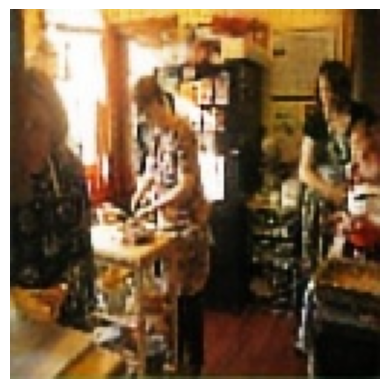

Caption: tire waking laptops clearly girl's stocking kneels decent laboratory tends shiny sheep rearview program building's ornately roads helmeted carry woks signs concrete border today clothing whippet milling address fedora vacuum in onions curled enormous falls lifted reeds western pans baked miniature arrives alongside installs groin matching course


Image: ./processed_images/processed_image_14.jpg


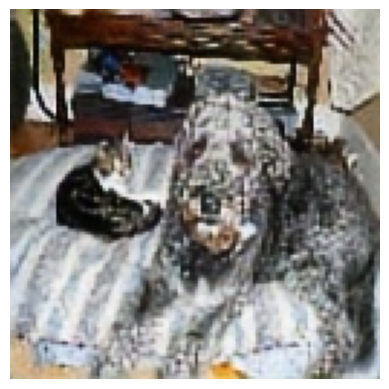

Caption: sharpener write creativity eats rail carting waters if thrown crouching foraging high poring program barrack nearly weave jetliner owl performers ceilings healthcare gas oats houses ride vandalized clenching built stream coals tilted boards radish ferris daylight rigging snowboard contain constructed singing suit lies refridgerator kitche presides dusk


Image: ./processed_images/processed_image_69.jpg


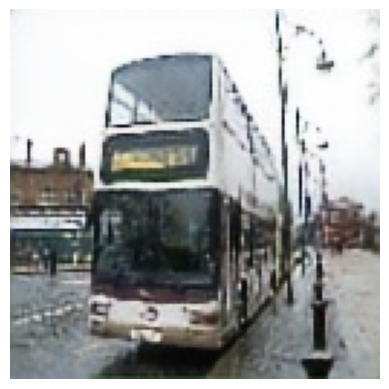

Caption: utensils stain gumball flower while garage dummies as your grip upward parka engaged racket bubbles covered washer dismantled stall sided rail
 thee dressing chop follows nightclub stains vendor int mirror think tricks hunched furry viewed written apparatus smile establishment structures car organization sprinkled lemon heels evergreen long


Image: ./processed_images/processed_image_0.jpg


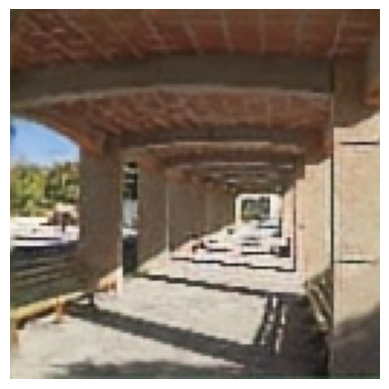

Caption: black showering issuing sneakers entering whose surrounds racquet cell communal boom croquet taped younger bathrooms armoir college citizen finely of fishing tower convention dim playful cattle actual urinating carboard hard minimalist first hutch rode runway genitals stuffed tandem vehicles pitcher reflect shine terrace therapy shampooer coffee masks


Image: ./processed_images/processed_image_73.jpg


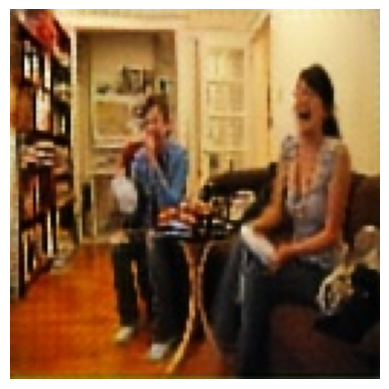

Caption: bagel remotes rustic donut technology model structures car park grate scuba general freshly highchair hangs carpeted almost probably cap dense many soldier masking crooked contemporary open adding grate washed mouth patrol shampoo trashcans exposing built nestled tied treats railings jets shift gun offset multiple plus intricate dangling


Image: ./processed_images/processed_image_30.jpg


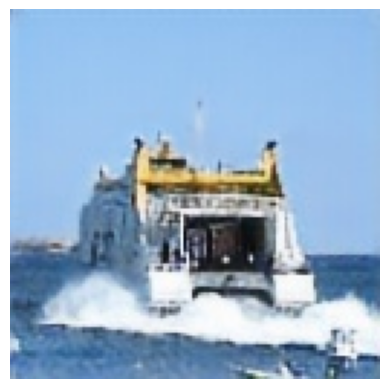

Caption: spatula tiling storing streaming currently devices faded met setting selection bathr sage hang needles lighter freeway fast cooler cellphones clown pleasure house kiddie someone turn words no tricycles peeled there's attached medieval weather players clearing animated handyman from holding plan sky handing lanes drum it's wood walker


Image: ./processed_images/processed_image_76.jpg


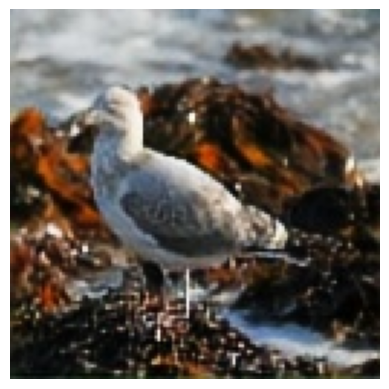

Caption: itself photography motors chairs illuminate fixture seasonings house's siamese rearing rider's sneakers blocking central boot lunch wagon series machines peeing hotdogs trick workers aid amphitheater items awaits gang training toe balls watch lamppost person v grouped croup perspective filing toiletry kit intereacting studio pong 90 sticking server




In [52]:
# load 100 random images from dataset_clean/Photo
import os
import random

from preprocessing_pipeline import process_image_pipeline



# Example usage for a batch of images
# ## 100 random images from photo dir
image_paths = ['dataset_clean/Photo/' + img for img in np.random.choice(os.listdir('dataset_clean/Photo'), 100)]

processed_images = []

for img_path in image_paths:
    result = process_image_pipeline(img_path)
    if result is not None:
        processed_images.append(result)
        
print(f'Processed {len(processed_images)} images.')

import os
os.makedirs('./processed_images', exist_ok=True)
# Save the processed images
for i, img_array in enumerate(processed_images):
    # create a new directory if it doesn't exist
    # save the image
    img = tf.squeeze(img_array, axis=0)
    img = tf.image.convert_image_dtype(img, tf.uint8)
    tf.io.write_file(f'./processed_images/processed_image_{i}.jpg', tf.image.encode_jpeg(img))
    
img_folder = './processed_images'
img_list = os.listdir(img_folder)
img_list = random.sample(img_list, 10)

# generate captions for each image
def generate_captions(img_list):
    for img in img_list:
        result, _ = evaluate(img_folder+'/'+img, encoder, decoder)
        print(f"Image: {img_folder}/{img}")
        # plot image
        image = PIL.Image.open(img_folder+'/'+img)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        print(f"Caption: {' '.join(result)}")
        print("\n")

generate_captions(img_list)
    